# Setup

## Imports

In [6]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end


0

## Logger Setups

In [8]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

MiniLogger{MiniLoggers.Squash, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}, DateFormat{Symbol("yyyy-mm-dd HH:MM:SS"), Tuple{Dates.DatePart{'y'}, Dates.Delim{Char, 1}, Dates.DatePart{'m'}, Dates.Delim{Char, 1}, Dates.DatePart{'d'}, Dates.Delim{Char, 1}, Dates.DatePart{'H'}, Dates.Delim{Char, 1}, Dates.DatePart{'M'}, Dates.Delim{Char, 1}, Dates.DatePart{'S'}}}, typeof(string)}(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(19) open, 0 bytes waiting)), VSCodeServer.io_send_callback), VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Error, LogLevel(-1), Dict{Any, Int64}(), true, MiniLoggers.Token[MiniLoggers.Token("[", MiniLoggers

# Loading Model and json

In [3]:
Mode10 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode10/Mode10.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode10.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

In [127]:
Mode10.Stuff["op_drive_params"]

Dict{String, Any} with 16 entries:
  "q_ef_3"     => Dict{Any, Any}("pulse_time"=>93.125, "Envelope Args"=>Dict{An…
  "q_half_ge0" => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "q_ef_2"     => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "q_ge_2"     => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "q_ge_1/2"   => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "sb_f2g3"    => Dict{Any, Any}("pulse_time"=>198.494, "Envelope Args"=>Dict{A…
  "sb_f1g2"    => Dict{Any, Any}("pulse_time"=>240.247, "Envelope Args"=>Dict{A…
  "q_ge_4/3"   => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "q_ge_3"     => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "q_ef_0"     => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "q_ge_0"     => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>Dict{A…
  "q_ge_1"     => Dict{Any, Any}("pulse_time"=>92.9688, "Envelope Args"=>D

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [9]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-11 12:14:20] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


[2024-11-11 12:14:36] Info: Done With Floquet Sweep


Progress:  18%|███████▌                                 |  ETA: 0:00:00

[2024-11-11 12:14:37] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0003601431233941637	 0.008955362524751698	 2.006697725228963
Stark shift res: [0.0003601431233941637, 55.646117735597855]


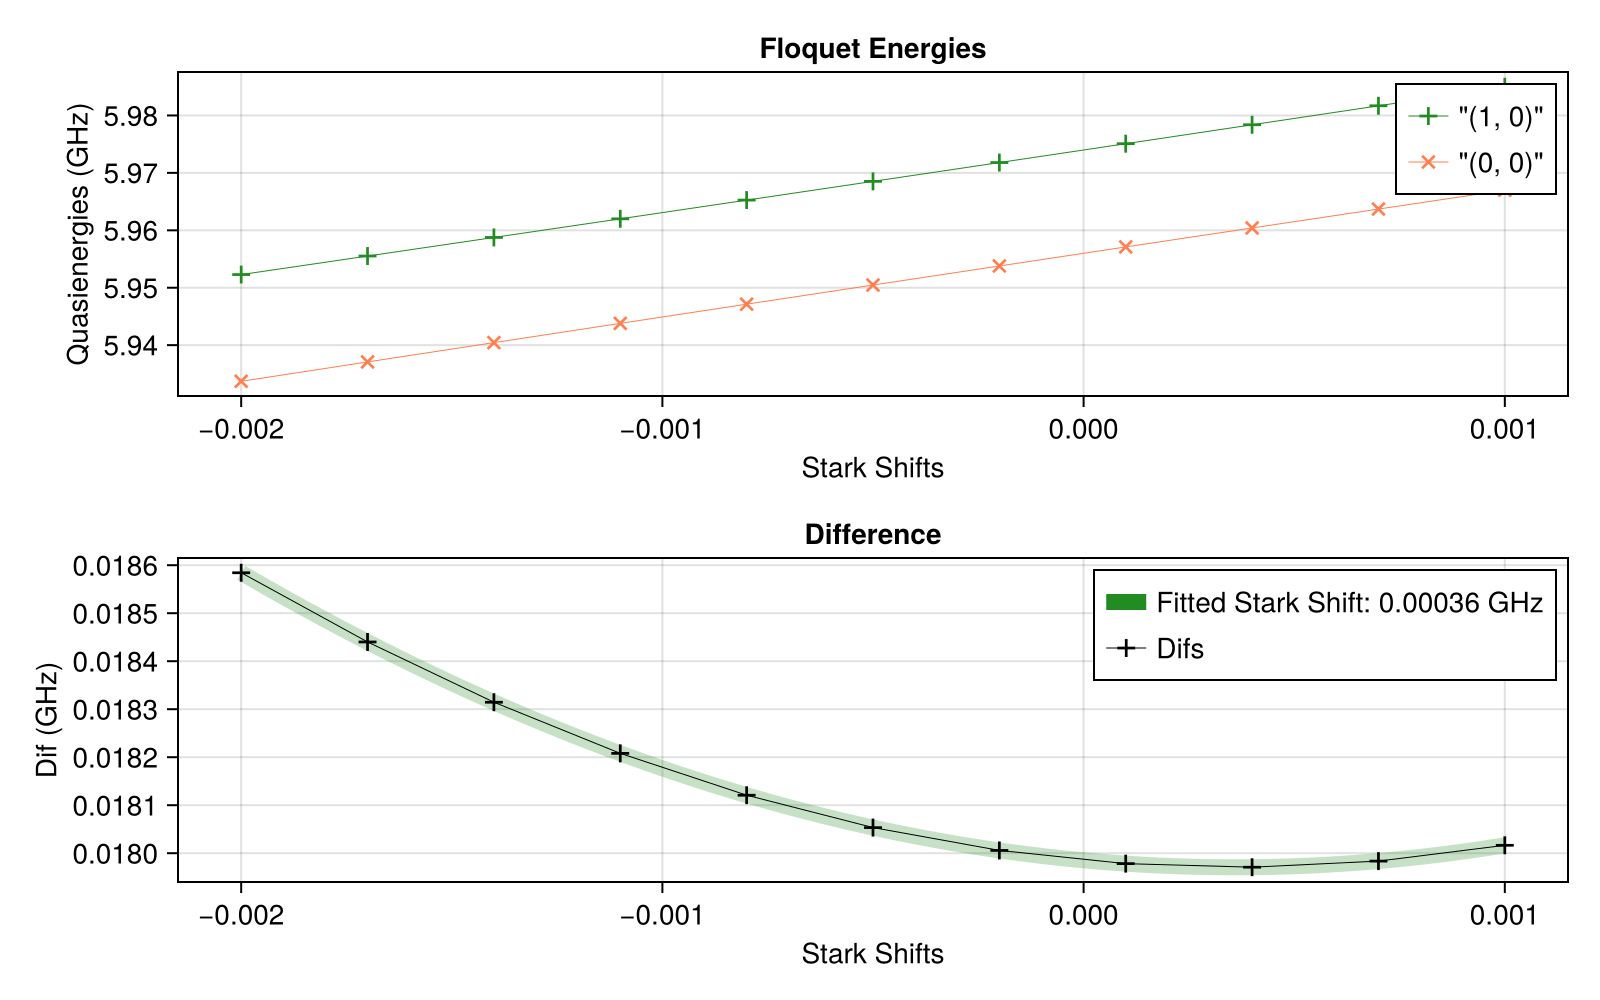

In [10]:
ge_ε = 0.00538
drive_op = Mode10.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode10, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [11]:

ψ1 = Mode10.dressed_states[(1,0)]+Mode10.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode10.dressed_states[(0,0)]+Mode10.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode10.dressed_energies[(1,0)]-Mode10.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode10.dressed_energies[(1,1)]-Mode10.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-11 12:14:52] Info: On Level 1
[2024-11-11 12:14:52] Info: On Step 1: t = 90.0
[2024-11-11 12:14:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-11 12:14:57] Info: Time Evolution Complete
[2024-11-11 12:14:57] Info: Done with Level_1_step_1
[2024-11-11 12:14:57] Info: Using Check Op
[2024-11-11 12:14:57] Info: Accurace: 0.997153303170892
[2024-11-11 12:14:57] Info: ------------------------------------------------------------------------------
[2024-11-11 12:14:57] Info: On Step 2: t = 92.5
[2024-11-11 12:14:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:15:00] Info: Time Evolution Complete
[2024-11-11 12:15:00] Info: Done with Level_1_step_2
[2024-11-11 12:15:00] Info: Using Check Op
[2024-11-11 12:15:00] Info: Accurace: 0.9995909670286233
[2024-11-11 12:15:00] Info: -------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999652
  "freq_d"        => 4.60417

In [12]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999652
  "freq_d"        => 4.60417

In [13]:
ψ = Mode10.dressed_states[(1,0)]+Mode10.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:15:58.399
It is being saved at: Data/
[2024-11-11 12:15:58] Info: Running operator q_ge_1/2
[2024-11-11 12:15:58] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-11 12:16:01] Info: Time Evolution Complete
[2024-11-11 12:16:01] Info: Saving Steps
[2024-11-11 12:16:07] Info: Done with Step_1
[2024-11-11 12:16:07] Info: Done With Running Sequence
[2024-11-11 12:16:07] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [14]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-11 12:16:11] Info: Making Plot


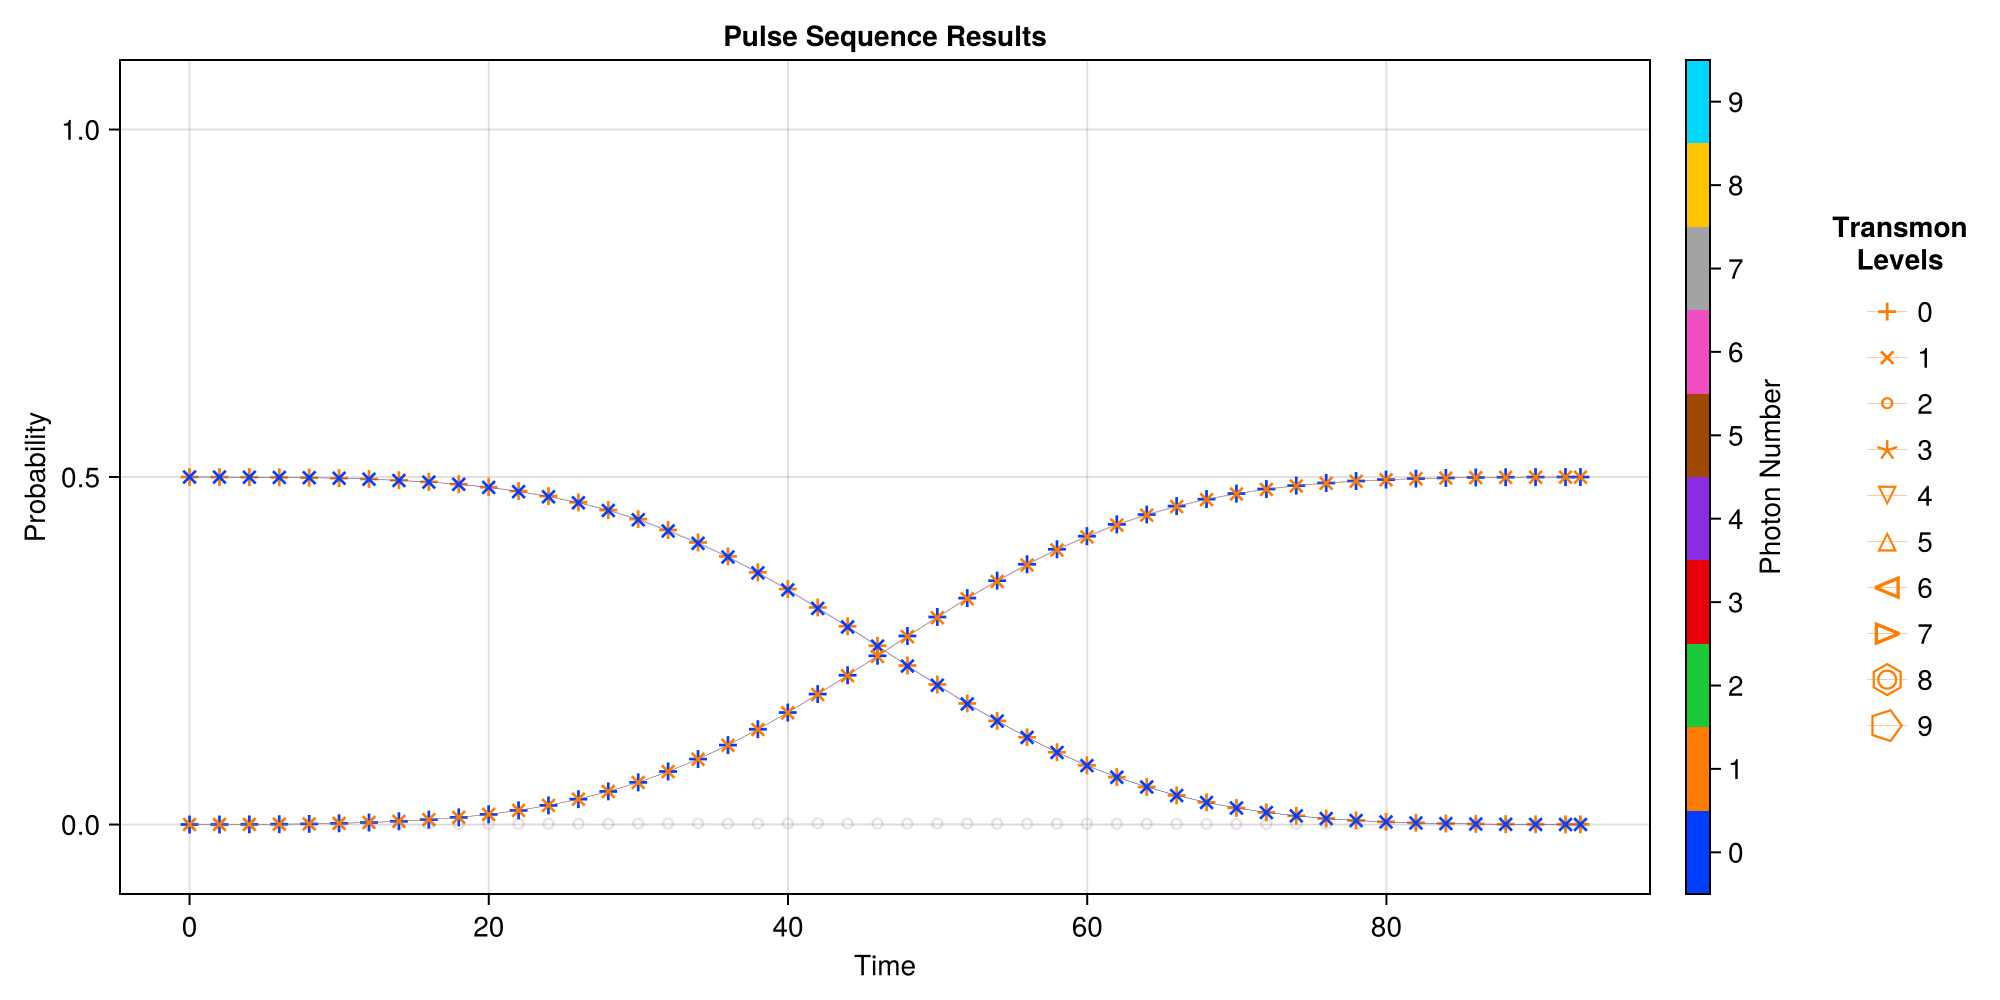

CairoMakie.Screen{IMAGE}


In [15]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [16]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.4999352024325403 + 4.4664045130789336e-17im
0.4997308965989798 - 1.3627964035319542e-18im


In [17]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997423473804 + 4.328846138790486e-17im

#### $|0,0\rangle \to |1,0\rangle$

In [18]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-11 12:16:20] Info: On Level 1
[2024-11-11 12:16:20] Info: On Step 1: t = 90.0
[2024-11-11 12:16:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:16:23] Info: Time Evolution Complete
[2024-11-11 12:16:23] Info: Done with Level_1_step_1
[2024-11-11 12:16:23] Info: Accurace: 0.9971510297449658
[2024-11-11 12:16:23] Info: ------------------------------------------------------------------------------
[2024-11-11 12:16:23] Info: On Step 2: t = 92.5
[2024-11-11 12:16:23] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:16:25] Info: Time Evolution Complete
[2024-11-11 12:16:25] Info: Done with Level_1_step_2
[2024-11-11 12:16:25] Info: Accurace: 0.9995900762537202
[2024-11-11 12:16:25] Info: ------------------------------------------------------------------------------
[2024-11-11 12:16:25] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999651
  "freq_d"        => 4.60422

In [19]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999651
  "freq_d"        => 4.60422

In [20]:
ψ = Mode10.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:17:22.396
It is being saved at: Data/
[2024-11-11 12:17:22] Info: Running operator q_ge_0
[2024-11-11 12:17:22] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-11 12:17:25] Info: Time Evolution Complete
[2024-11-11 12:17:25] Info: Saving Steps
[2024-11-11 12:17:26] Info: Done with Step_1
[2024-11-11 12:17:26] Info: Done With Running Sequence
[2024-11-11 12:17:26] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [21]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-11 12:17:27] Info: Making Plot


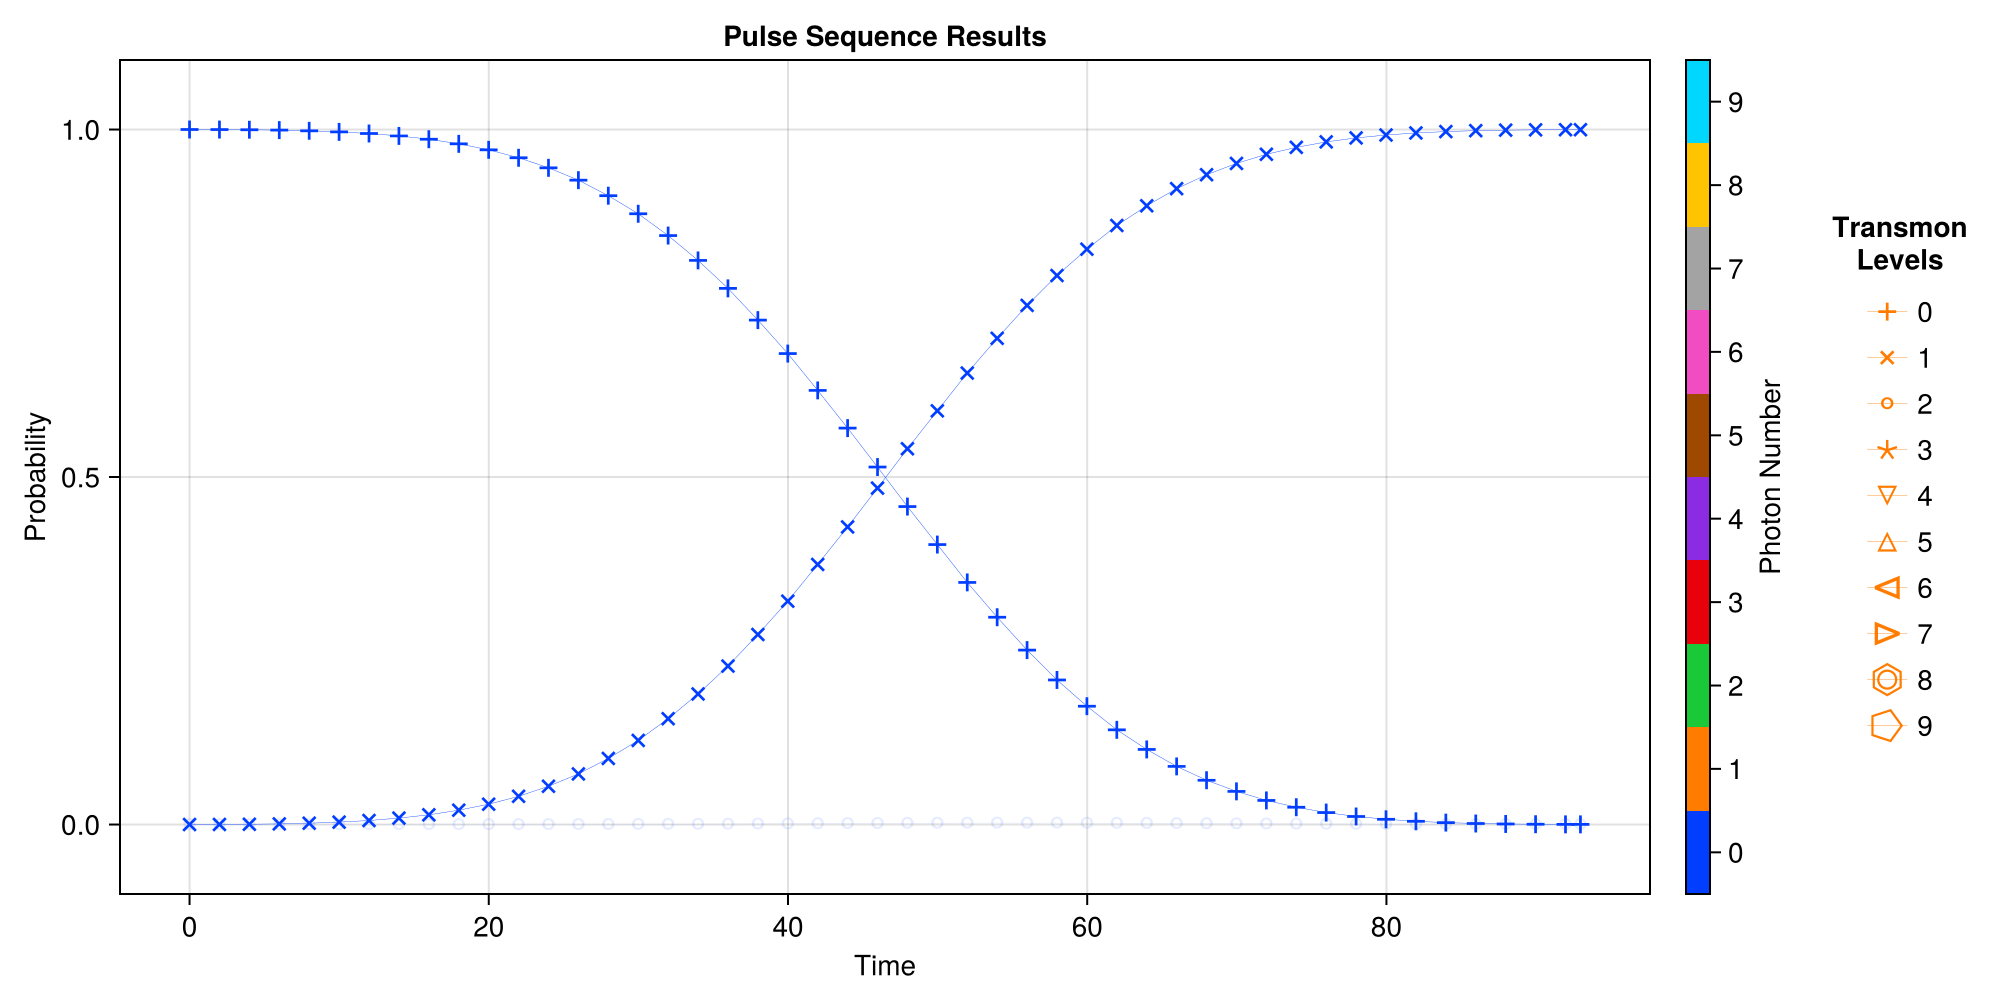

CairoMakie.Screen{IMAGE}


In [22]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [23]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.00022518005384146285 - 9.619617038834021e-23im
0.9997125595048365 - 3.456263874066019e-17im
6.185627412505157e-5 + 1.9200939278490996e-21im


In [24]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997423473804 + 4.328846138790486e-17im

#### $|0,1\rangle \to |1,1\rangle$

In [25]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-11 12:17:30] Info: On Level 1
[2024-11-11 12:17:30] Info: On Step 1: t = 90.0
[2024-11-11 12:17:30] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:17:33] Info: Time Evolution Complete
[2024-11-11 12:17:33] Info: Done with Level_1_step_1
[2024-11-11 12:17:33] Info: Accurace: 0.9972091343835019
[2024-11-11 12:17:33] Info: ------------------------------------------------------------------------------
[2024-11-11 12:17:33] Info: On Step 2: t = 92.5
[2024-11-11 12:17:33] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:17:35] Info: Time Evolution Complete
[2024-11-11 12:17:35] Info: Done with Level_1_step_2
[2024-11-11 12:17:35] Info: Accurace: 0.9996505045315796
[2024-11-11 12:17:35] Info: ------------------------------------------------------------------------------
[2024-11-11 12:17:35] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60413

In [26]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999712
  "freq_d"        => 4.60413

In [27]:
ψ = Mode10.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:18:32.364
It is being saved at: Data/
[2024-11-11 12:18:32] Info: Running operator q_ge_1
[2024-11-11 12:18:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-11 12:18:34] Info: Time Evolution Complete
[2024-11-11 12:18:34] Info: Saving Steps
[2024-11-11 12:18:35] Info: Done with Step_1
[2024-11-11 12:18:35] Info: Done With Running Sequence
[2024-11-11 12:18:35] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [28]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-11 12:18:36] Info: Making Plot


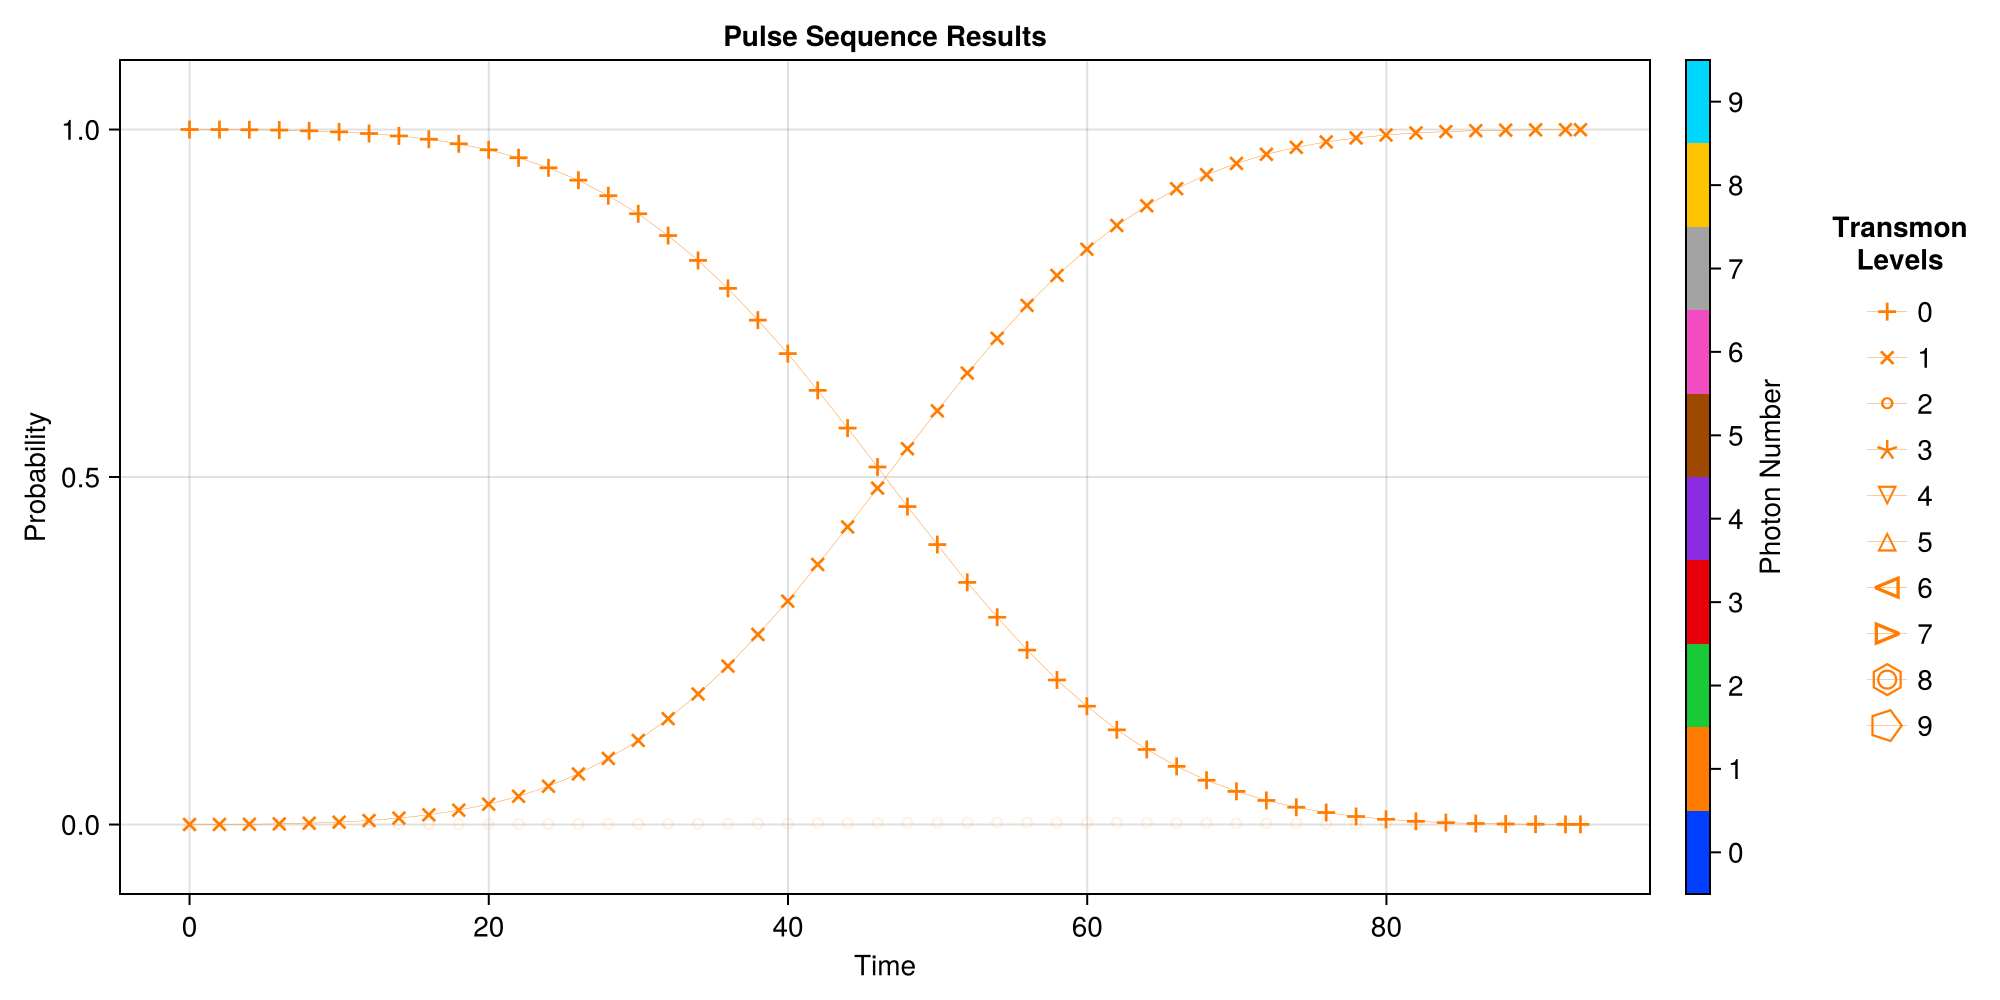

CairoMakie.Screen{IMAGE}


In [29]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [30]:
EVs[(1,1)][end]

0.9997119501916366 - 2.2113686823297357e-18im

In [31]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999989393269667 - 2.2169936197968076e-18im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [32]:

ψ1 = Mode10.dressed_states[(0,0)]+(Mode10.dressed_states[(1,1)]+Mode10.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode10.dressed_states[(1,0)]+(Mode10.dressed_states[(0,1)]+Mode10.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode10.dressed_energies[(1,0)]-Mode10.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode10.dressed_energies[(1,1)]-Mode10.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode10.dressed_energies[(1,3)]-Mode10.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-11 12:18:38] Info: On Level 1
[2024-11-11 12:18:38] Info: On Step 1: t = 90.0
[2024-11-11 12:18:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:18:41] Info: Time Evolution Complete
[2024-11-11 12:18:41] Info: Done with Level_1_step_1
[2024-11-11 12:18:41] Info: Using Check Op
[2024-11-11 12:18:41] Info: Accurace: 0.9970319232887828
[2024-11-11 12:18:41] Info: ------------------------------------------------------------------------------
[2024-11-11 12:18:41] Info: On Step 2: t = 92.5
[2024-11-11 12:18:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:18:43] Info: Time Evolution Complete
[2024-11-11 12:18:43] Info: Done with Level_1_step_2
[2024-11-11 12:18:43] Info: Using Check Op
[2024-11-11 12:18:43] Info: Accurace: 0.999461566974261
[2024-11-11 12:18:43] Info: -------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999521
  "freq_d"        => 4.60409

In [33]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999521
  "freq_d"        => 4.60409

In [34]:
ψ = Mode10.dressed_states[(1,1)]+(Mode10.dressed_states[(0,0)]+Mode10.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:19:39.970
It is being saved at: Data/
[2024-11-11 12:19:39] Info: Running operator q_ge_4/3
[2024-11-11 12:19:39] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-11 12:19:43] Info: Time Evolution Complete
[2024-11-11 12:19:43] Info: Saving Steps
[2024-11-11 12:19:44] Info: Done with Step_1
[2024-11-11 12:19:44] Info: Done With Running Sequence
[2024-11-11 12:19:44] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [35]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-11 12:19:45] Info: Making Plot


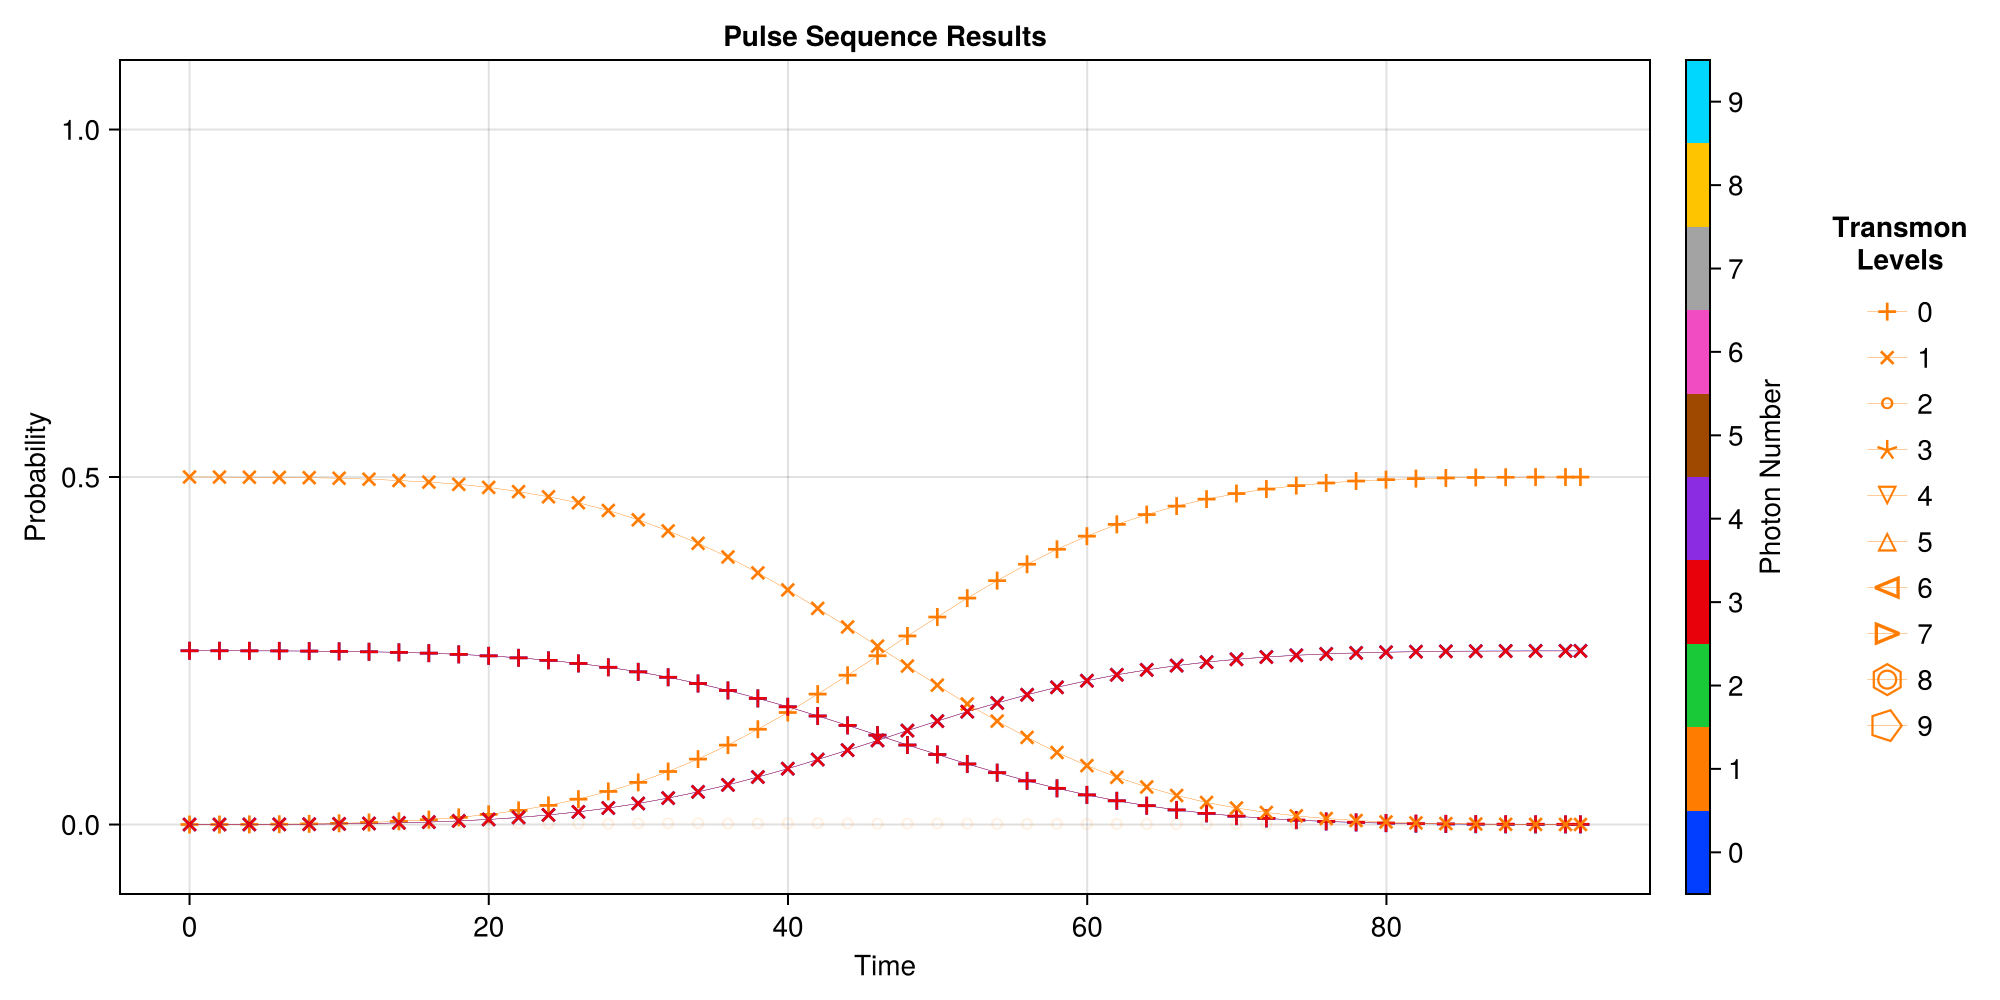

CairoMakie.Screen{IMAGE}


In [36]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [37]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.4999143036145832 - 1.3012290893235222e-19im
0.24998174500361356 - 1.0407147888654128e-17im
0.24962872557108878 + 2.993307045309195e-18im


In [38]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.999999832472229 - 7.5575606116529e-18im

#### $|0,2\rangle \to |1,2\rangle$

In [39]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-11 12:19:47] Info: On Level 1
[2024-11-11 12:19:47] Info: On Step 1: t = 90.0
[2024-11-11 12:19:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:19:49] Info: Time Evolution Complete
[2024-11-11 12:19:49] Info: Done with Level_1_step_1
[2024-11-11 12:19:49] Info: Accurace: 0.9972083518715644
[2024-11-11 12:19:49] Info: ------------------------------------------------------------------------------
[2024-11-11 12:19:49] Info: On Step 2: t = 92.5
[2024-11-11 12:19:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:19:52] Info: Time Evolution Complete
[2024-11-11 12:19:52] Info: Done with Level_1_step_2
[2024-11-11 12:19:52] Info: Accurace: 0.9996512350550697
[2024-11-11 12:19:52] Info: ------------------------------------------------------------------------------
[2024-11-11 12:19:52] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60403

In [40]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60403

In [41]:
ψ = Mode10.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:20:48.214
It is being saved at: Data/
[2024-11-11 12:20:48] Info: Running operator q_ge_2
[2024-11-11 12:20:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:20:50] Info: Time Evolution Complete
[2024-11-11 12:20:50] Info: Saving Steps
[2024-11-11 12:20:51] Info: Done with Step_1
[2024-11-11 12:20:51] Info: Done With Running Sequence
[2024-11-11 12:20:51] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [42]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-11 12:20:52] Info: Making Plot


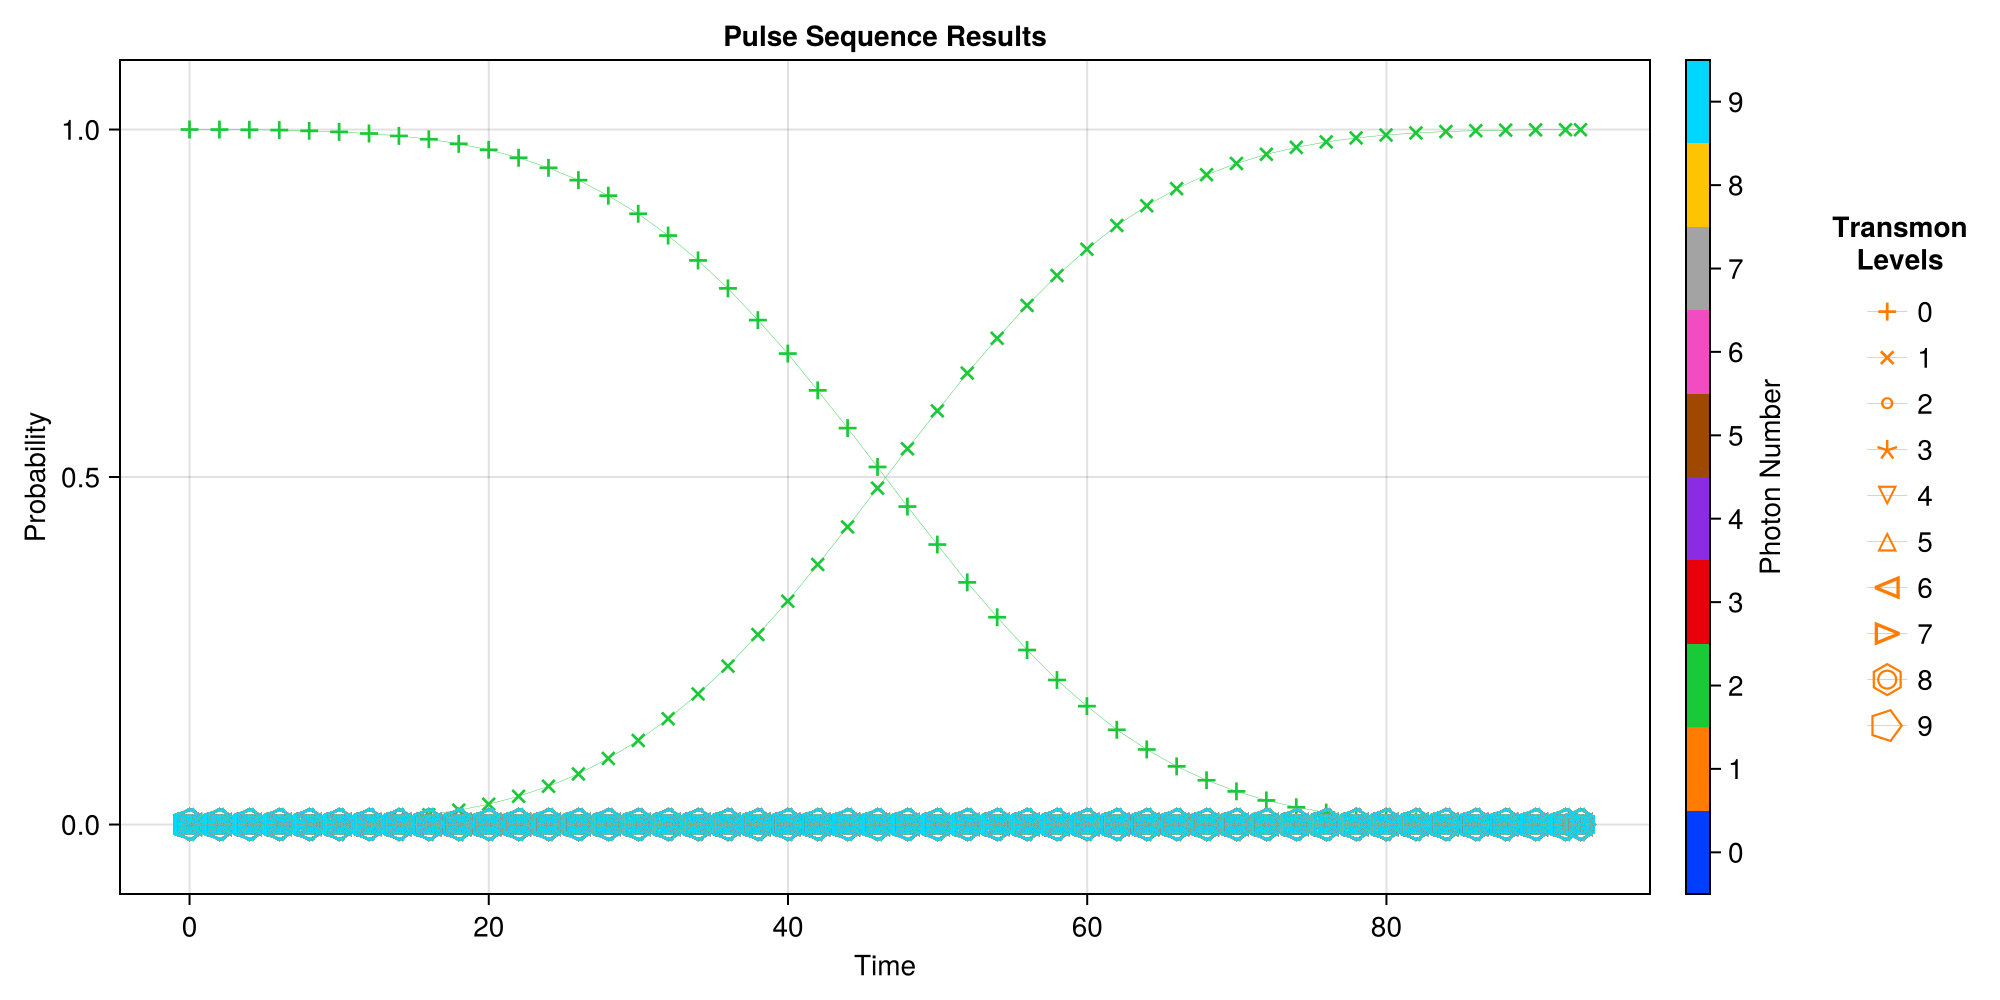

CairoMakie.Screen{IMAGE}


In [43]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ge2_res["times"], EVs, plot_every = 10)

In [44]:
EVs[(1,2)][end]

0.9997130479373723 - 4.0461912756373184e-17im

In [45]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999949725141 - 4.046403348389435e-17im

#### $|0,3\rangle \to |1,3\rangle$

In [46]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-11 12:20:54] Info: On Level 1
[2024-11-11 12:20:54] Info: On Step 1: t = 90.0
[2024-11-11 12:20:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:20:57] Info: Time Evolution Complete
[2024-11-11 12:20:57] Info: Done with Level_1_step_1
[2024-11-11 12:20:57] Info: Accurace: 0.9972064807446263
[2024-11-11 12:20:57] Info: ------------------------------------------------------------------------------
[2024-11-11 12:20:57] Info: On Step 2: t = 92.5
[2024-11-11 12:20:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:20:59] Info: Time Evolution Complete
[2024-11-11 12:20:59] Info: Done with Level_1_step_2
[2024-11-11 12:20:59] Info: Accurace: 0.999650938649371
[2024-11-11 12:20:59] Info: ------------------------------------------------------------------------------
[2024-11-11 12:20:59] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60393

In [47]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60393

In [48]:
ψ = Mode10.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:21:56.940
It is being saved at: Data/
[2024-11-11 12:21:56] Info: Running operator q_ge_3
[2024-11-11 12:21:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:21:58] Info: Time Evolution Complete
[2024-11-11 12:21:58] Info: Saving Steps
[2024-11-11 12:21:59] Info: Done with Step_1
[2024-11-11 12:21:59] Info: Done With Running Sequence
[2024-11-11 12:21:59] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [49]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-11 12:22:00] Info: Making Plot


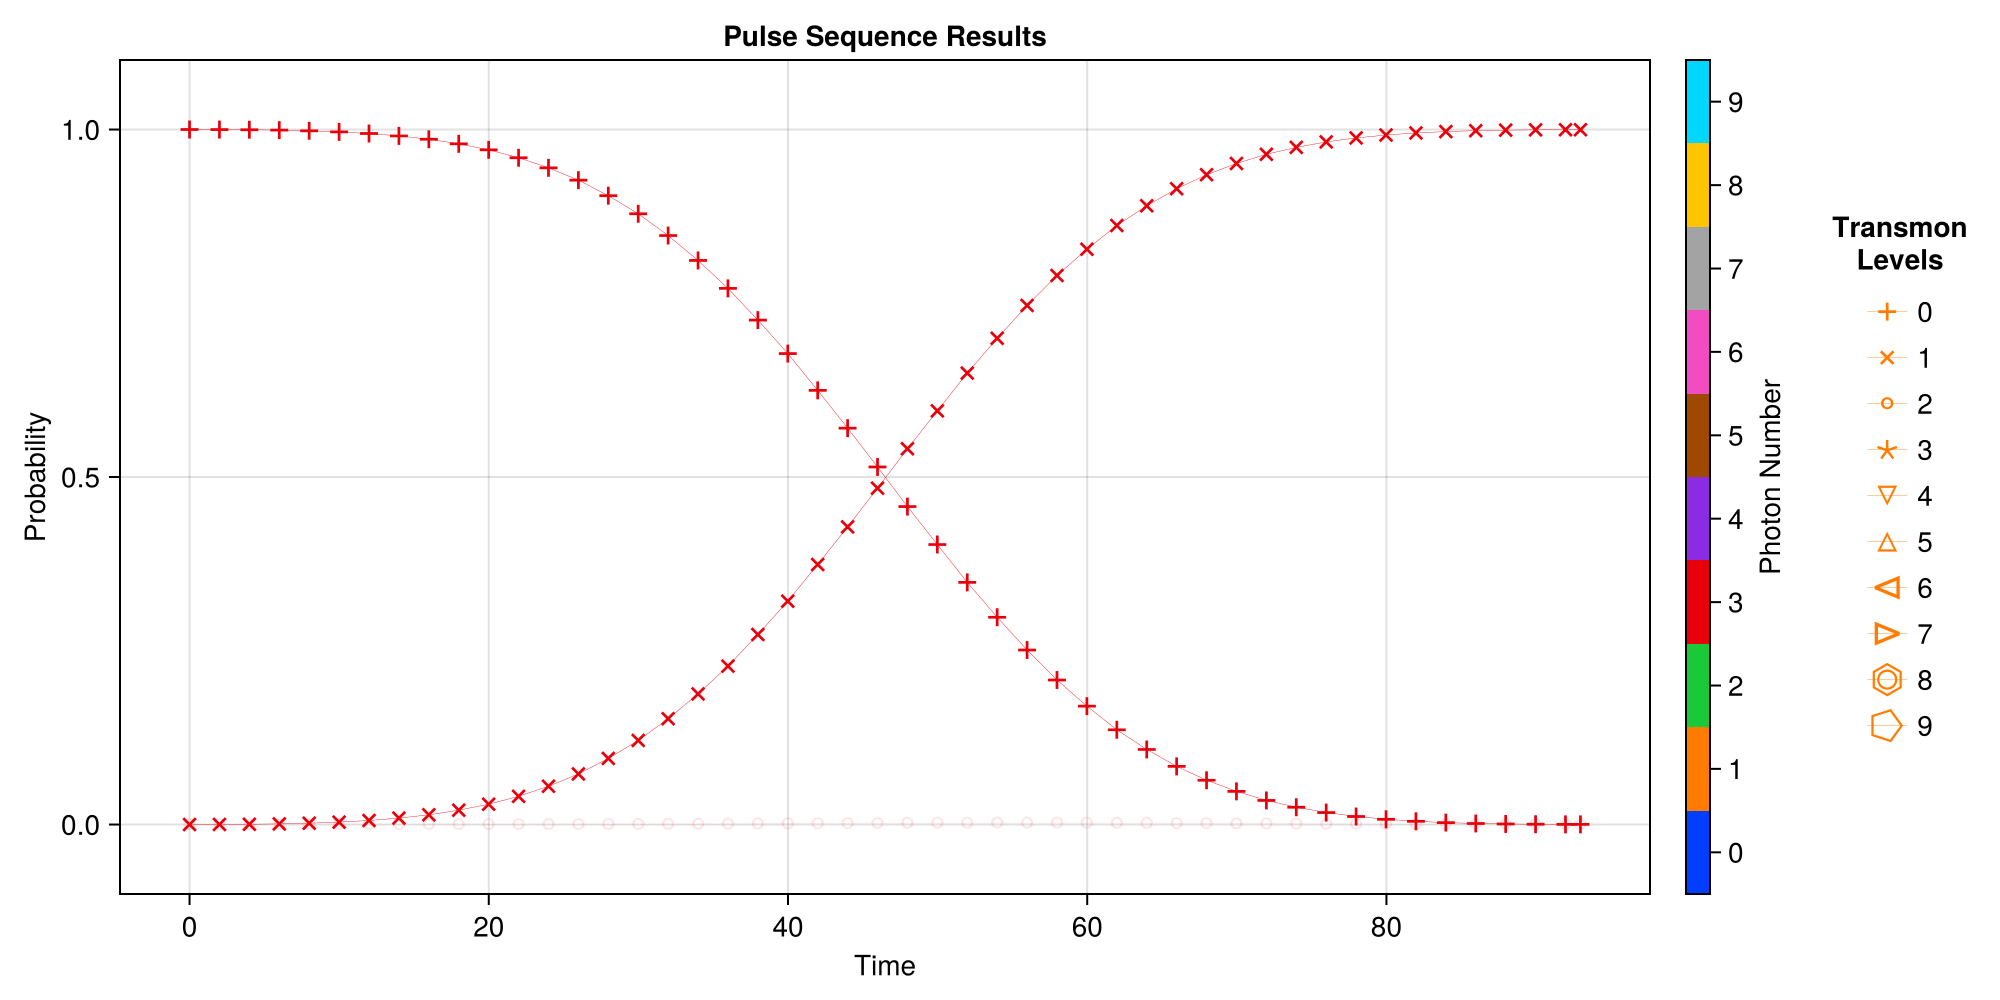

CairoMakie.Screen{IMAGE}


In [50]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [51]:
EVs[(1,3)][end]

0.9997130887006446 - 2.4412332855406207e-17im

In [52]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999999995542 - 2.448928175539365e-17im

### Guassian e -> f

In [53]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-11 12:22:04] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


[2024-11-11 12:22:10] Info: Done With Floquet Sweep
[2024-11-11 12:22:10] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0001651942225009634	 0.008957803695205704	 2.0062779557778696
Stark shift res: [0.0001651942225009634, 55.64259267004516]


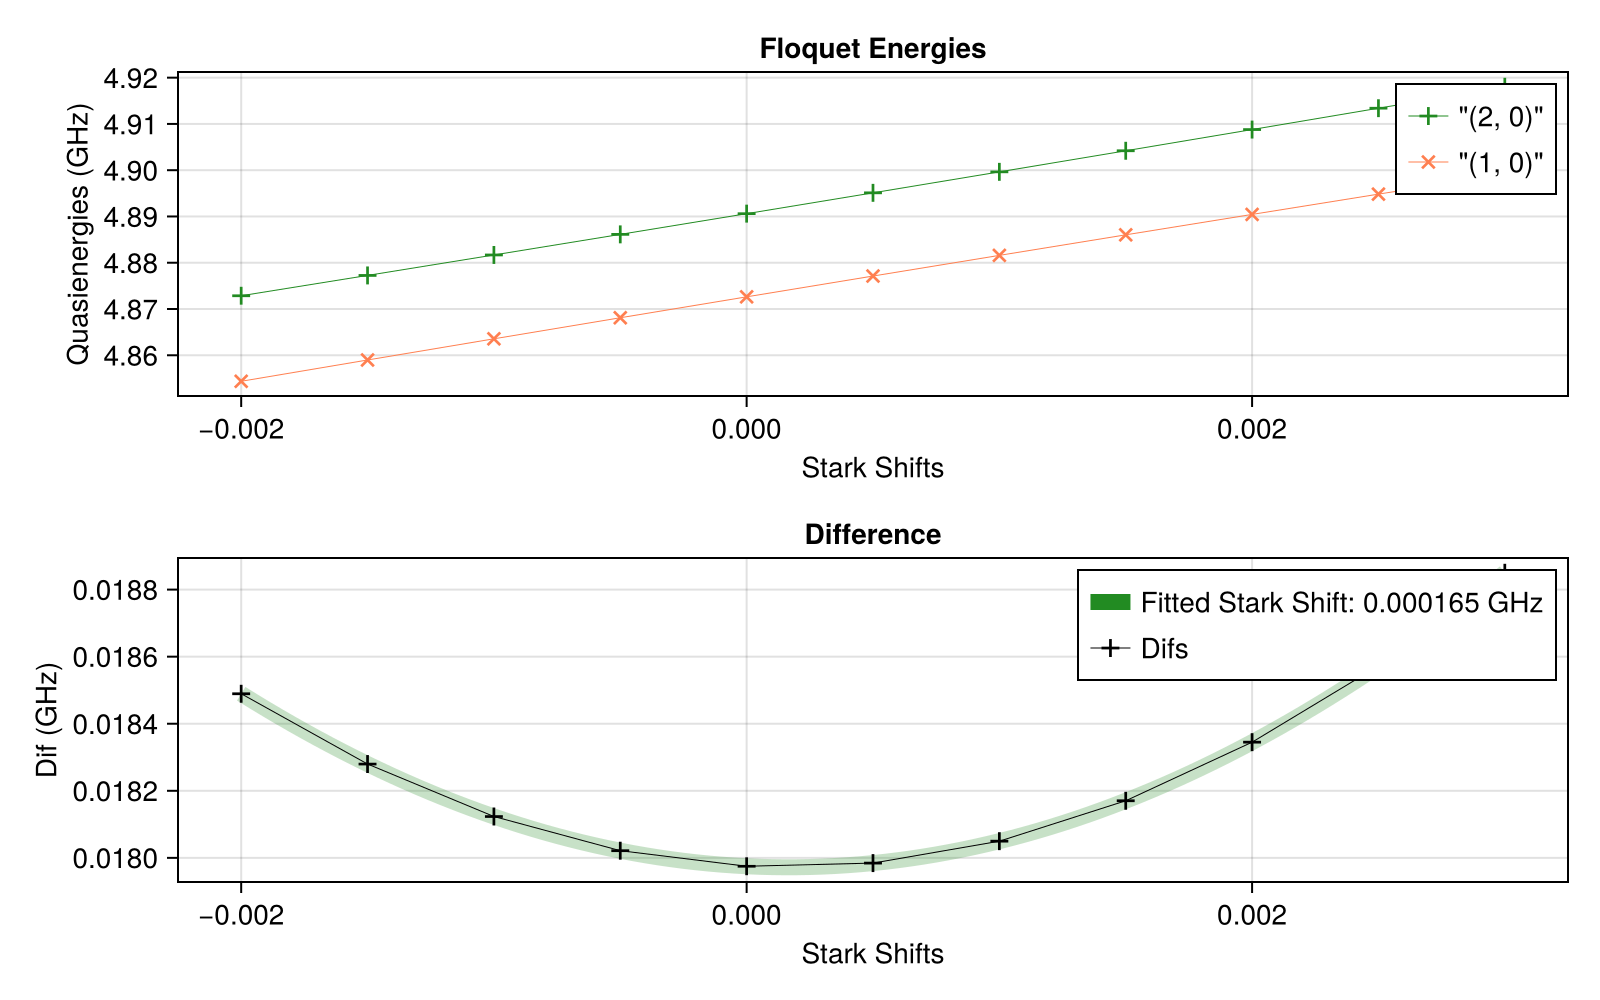

In [54]:
ef_ε = 0.00385
drive_op = Mode10.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode10, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [55]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-11 12:22:10] Info: On Level 1
[2024-11-11 12:22:10] Info: On Step 1: t = 90.0
[2024-11-11 12:22:10] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:22:13] Info: Time Evolution Complete
[2024-11-11 12:22:13] Info: Done with Level_1_step_1
[2024-11-11 12:22:13] Info: Accurace: 0.9973733469799517
[2024-11-11 12:22:13] Info: ------------------------------------------------------------------------------
[2024-11-11 12:22:13] Info: On Step 2: t = 92.5
[2024-11-11 12:22:13] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:22:15] Info: Time Evolution Complete
[2024-11-11 12:22:15] Info: Done with Level_1_step_2
[2024-11-11 12:22:15] Info: Accurace: 0.999828097231328
[2024-11-11 12:22:15] Info: ------------------------------------------------------------------------------
[2024-11-11 12:22:15] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.49569

In [56]:
#Mode10.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.49569

In [57]:
ψ = Mode10.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:23:10.543
It is being saved at: Data/
[2024-11-11 12:23:10] Info: Running operator q_ef_0
[2024-11-11 12:23:10] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-11 12:23:12] Info: Time Evolution Complete
[2024-11-11 12:23:12] Info: Saving Steps
[2024-11-11 12:23:13] Info: Done with Step_1
[2024-11-11 12:23:13] Info: Done With Running Sequence
[2024-11-11 12:23:13] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [58]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-11 12:23:14] Info: Making Plot


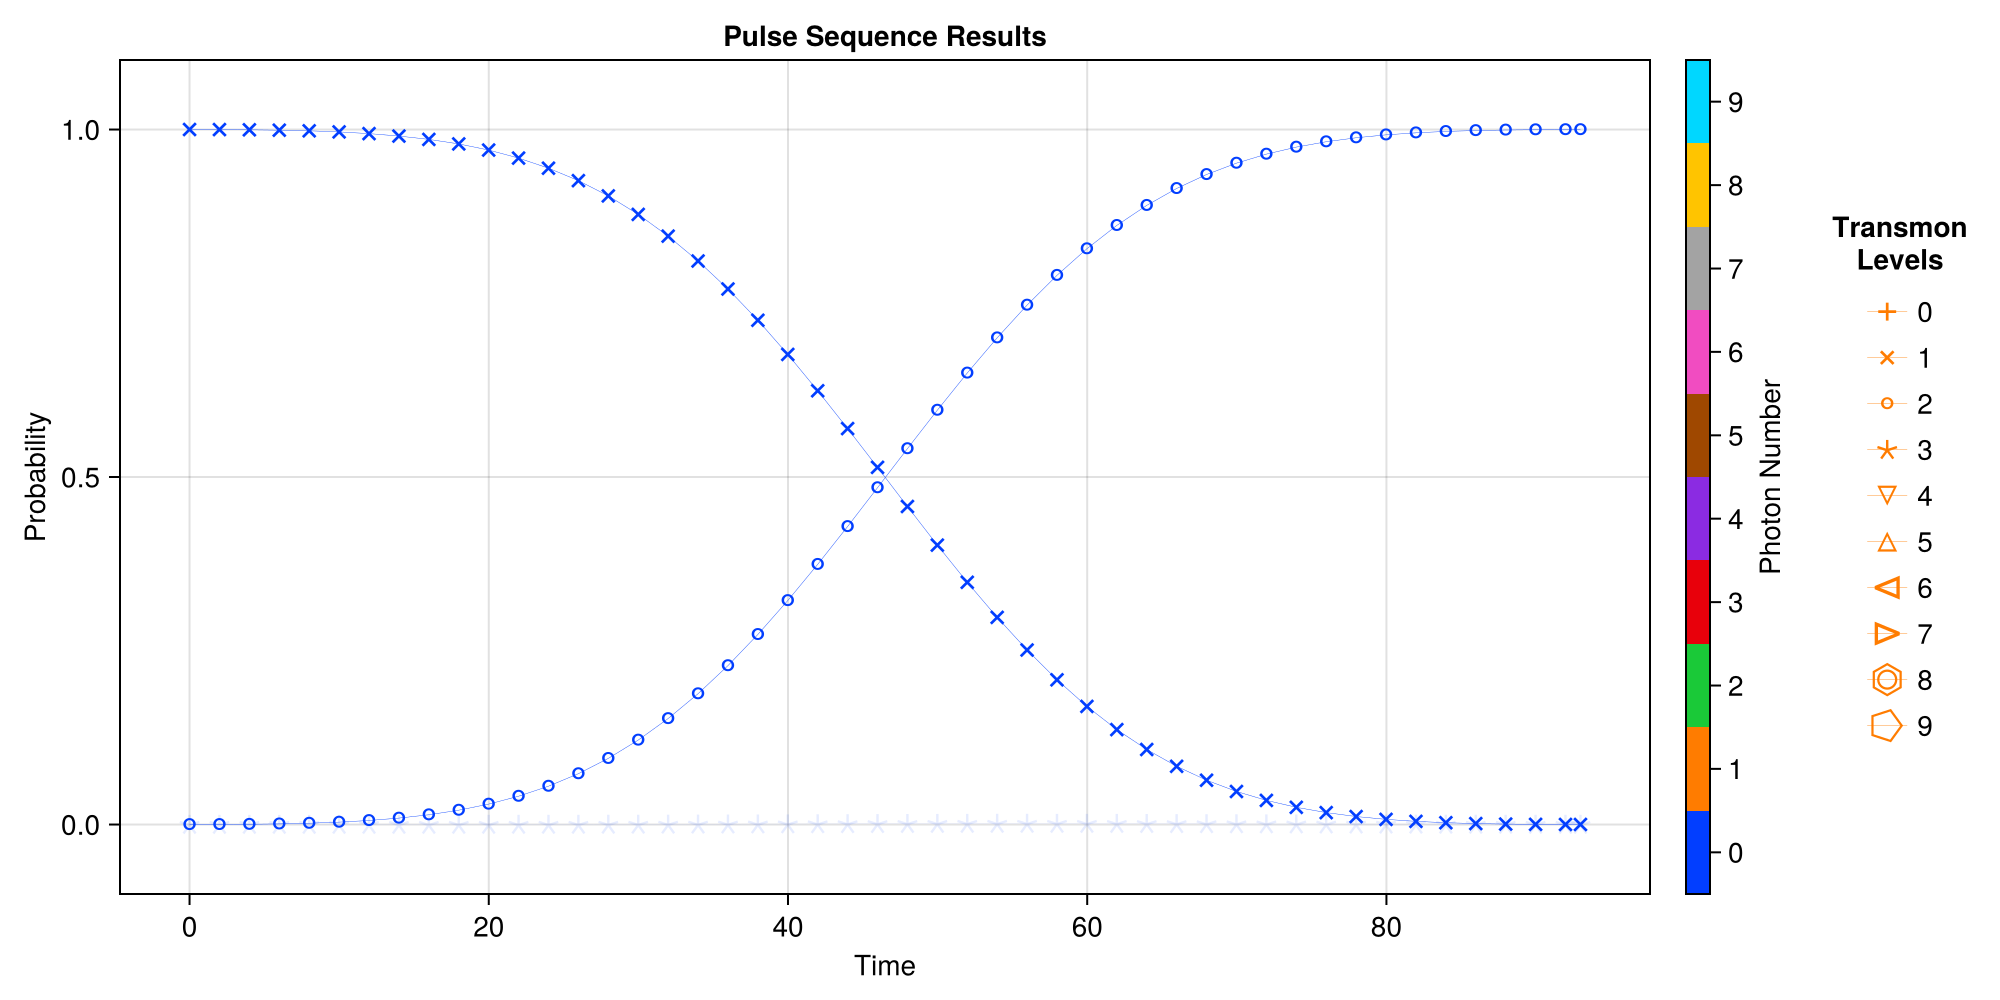

CairoMakie.Screen{IMAGE}


In [59]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [60]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.577566716897639e-5 - 7.58743701863641e-22im
4.672877040377739e-5 + 1.9478680761408083e-21im
0.9998918335050514 - 5.287756240100328e-17im
4.2973482488176945e-5 + 1.0672819529660886e-21im


In [61]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999973116800599 - 5.292419846245743e-17im

##### $|1,1\rangle \to |2,1\rangle$

In [62]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-11 12:23:16] Info: On Level 1
[2024-11-11 12:23:16] Info: On Step 1: t = 90.0
[2024-11-11 12:23:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:23:18] Info: Time Evolution Complete
[2024-11-11 12:23:18] Info: Done with Level_1_step_1
[2024-11-11 12:23:18] Info: Accurace: 0.9973774495711311
[2024-11-11 12:23:18] Info: ------------------------------------------------------------------------------
[2024-11-11 12:23:18] Info: On Step 2: t = 92.5
[2024-11-11 12:23:18] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:23:20] Info: Time Evolution Complete
[2024-11-11 12:23:20] Info: Done with Level_1_step_2
[2024-11-11 12:23:20] Info: Accurace: 0.9998335140081971
[2024-11-11 12:23:20] Info: ------------------------------------------------------------------------------
[2024-11-11 12:23:20] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.4956

In [63]:
#Mode10.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.4956

In [64]:
ψ = Mode10.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:24:17.933
It is being saved at: Data/
[2024-11-11 12:24:17] Info: Running operator q_ef_1
[2024-11-11 12:24:17] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:24:20] Info: Time Evolution Complete
[2024-11-11 12:24:20] Info: Saving Steps
[2024-11-11 12:24:21] Info: Done with Step_1
[2024-11-11 12:24:21] Info: Done With Running Sequence
[2024-11-11 12:24:21] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [65]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-11 12:24:23] Info: Making Plot


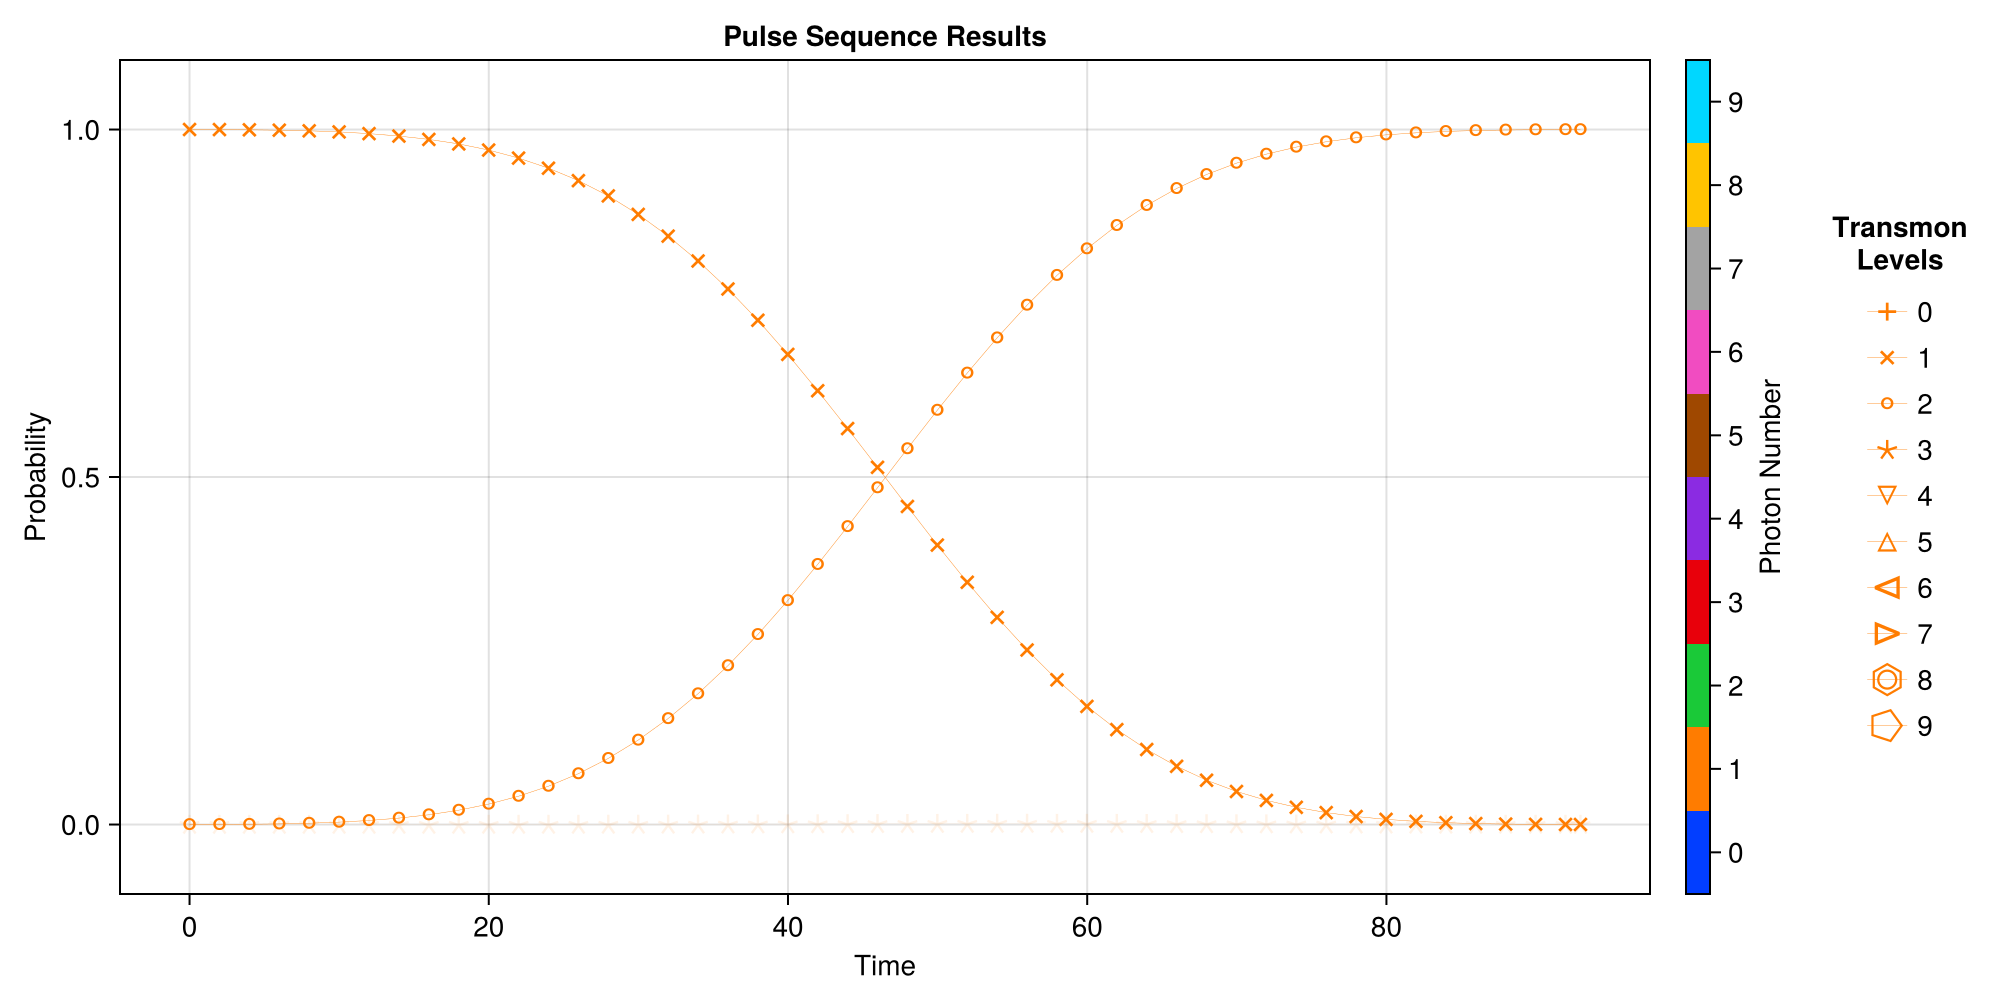

CairoMakie.Screen{IMAGE}


In [66]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [67]:
EVs[(2,1)][end]

0.9998945144809228 - 2.910440712623985e-17im

In [68]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999764128984 - 2.907439285667391e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [69]:
ψ1 = Mode10.dressed_states[(1,0)]/sqrt(2)+Mode10.dressed_states[(2,0)]+Mode10.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode10.dressed_states[(2,0)]+(Mode10.dressed_states[(1,0)]+Mode10.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode10.dressed_energies[(2,0)]-Mode10.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode10.dressed_energies[(2,1)]-Mode10.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode10.dressed_energies[(2,3)]-Mode10.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-11 12:24:25] Info: On Level 1
[2024-11-11 12:24:25] Info: On Step 1: t = 90.0
[2024-11-11 12:24:25] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:24:27] Info: Time Evolution Complete
[2024-11-11 12:24:27] Info: Done with Level_1_step_1
[2024-11-11 12:24:27] Info: Using Check Op
[2024-11-11 12:24:27] Info: Accurace: 0.9991708910145108
[2024-11-11 12:24:27] Info: ------------------------------------------------------------------------------
[2024-11-11 12:24:27] Info: On Step 2: t = 92.5
[2024-11-11 12:24:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:24:29] Info: Time Evolution Complete
[2024-11-11 12:24:29] Info: Done with Level_1_step_2
[2024-11-11 12:24:29] Info: Using Check Op
[2024-11-11 12:24:29] Info: Accurace: 0.999713014621721
[2024-11-11 12:24:29] Info: -------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999723
  "freq_d"        => 4.49555

In [70]:
#Mode10.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999723
  "freq_d"        => 4.49555

In [71]:
ψ = Mode10.dressed_states[(1,0)]/sqrt(2)+Mode10.dressed_states[(2,0)]+Mode10.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:25:25.152
It is being saved at: Data/
[2024-11-11 12:25:25] Info: Running operator q_ef_3/2
[2024-11-11 12:25:25] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:25:28] Info: Time Evolution Complete
[2024-11-11 12:25:28] Info: Saving Steps
[2024-11-11 12:25:28] Info: Done with Step_1
[2024-11-11 12:25:28] Info: Done With Running Sequence
[2024-11-11 12:25:28] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [72]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-11 12:25:29] Info: Making Plot


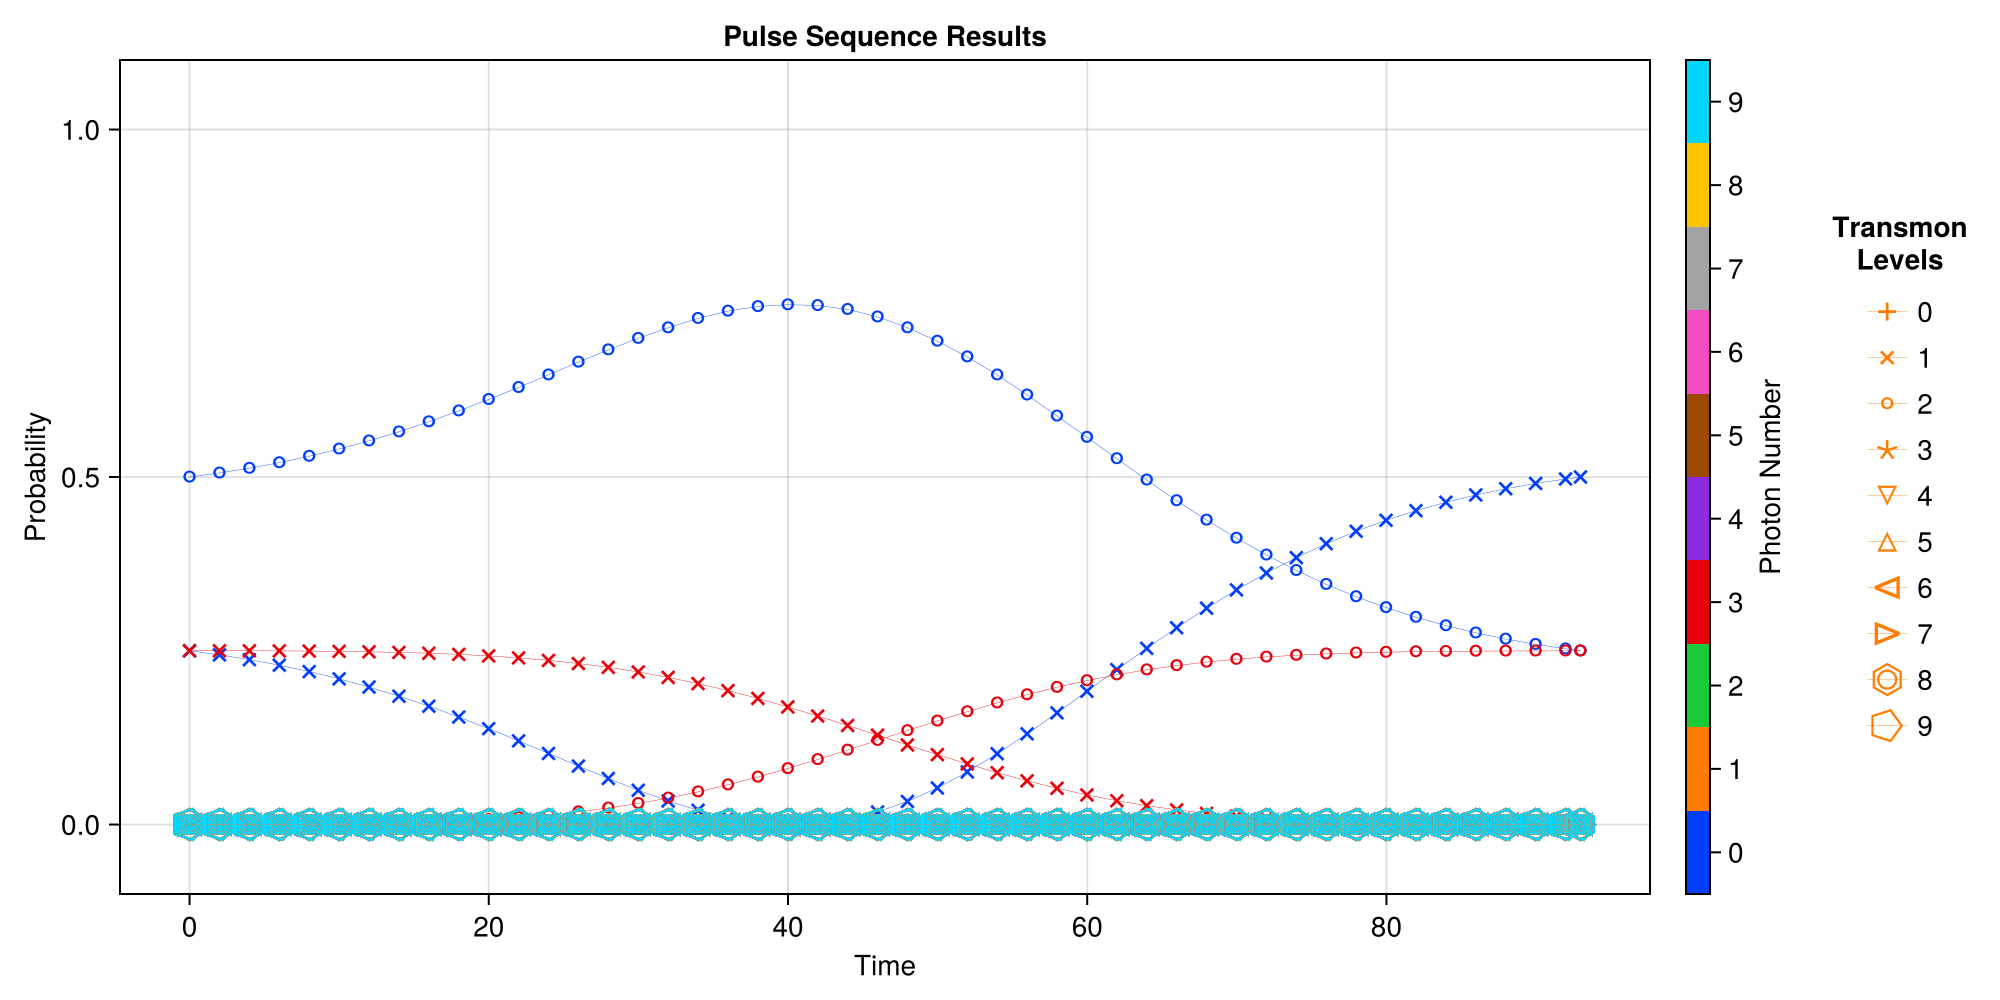

CairoMakie.Screen{IMAGE}


In [73]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [74]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.24990541120301638 + 4.576918623827177e-17im
0.5000103639666423 - 2.261304862103243e-17im
0.24980919069126892 - 4.841570669165179e-18im


In [75]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998236104652 + 1.8322846063695552e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [76]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-11 12:25:32] Info: On Level 1
[2024-11-11 12:25:32] Info: On Step 1: t = 90.0
[2024-11-11 12:25:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:25:34] Info: Time Evolution Complete
[2024-11-11 12:25:34] Info: Done with Level_1_step_1
[2024-11-11 12:25:34] Info: Accurace: 0.9973760452575671
[2024-11-11 12:25:34] Info: ------------------------------------------------------------------------------
[2024-11-11 12:25:34] Info: On Step 2: t = 92.5
[2024-11-11 12:25:34] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:25:36] Info: Time Evolution Complete
[2024-11-11 12:25:37] Info: Done with Level_1_step_2
[2024-11-11 12:25:37] Info: Accurace: 0.9998332593885919
[2024-11-11 12:25:37] Info: ------------------------------------------------------------------------------
[2024-11-11 12:25:37] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999895
  "freq_d"        => 4.4955

In [77]:
#Mode10.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999895
  "freq_d"        => 4.4955

In [78]:
ψ = Mode10.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:26:57.925
It is being saved at: Data/
[2024-11-11 12:26:57] Info: Running operator q_ef_2
[2024-11-11 12:26:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:27:00] Info: Time Evolution Complete
[2024-11-11 12:27:00] Info: Saving Steps
[2024-11-11 12:27:01] Info: Done with Step_1
[2024-11-11 12:27:01] Info: Done With Running Sequence
[2024-11-11 12:27:01] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [79]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-11 12:27:02] Info: Making Plot


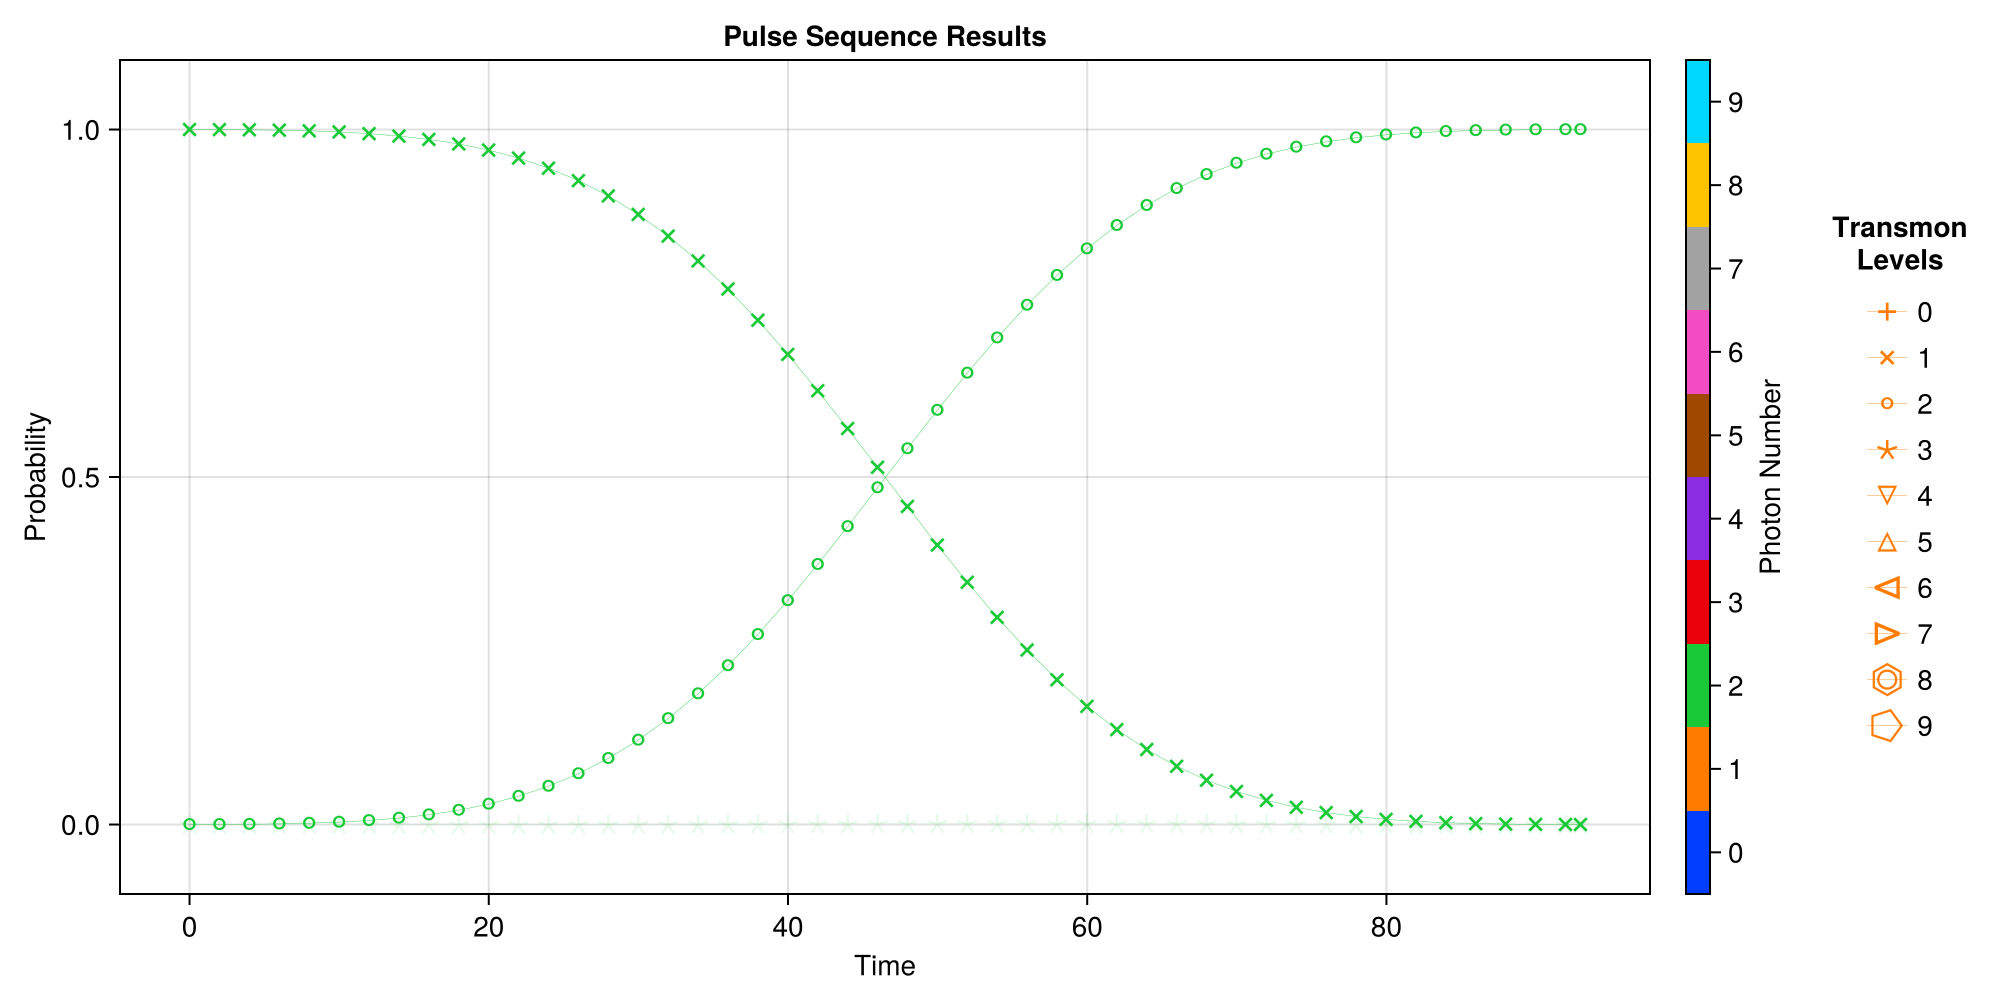

CairoMakie.Screen{IMAGE}


In [80]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [81]:
EVs[(2,2)][end]

0.9998945529566842 + 7.04949609185513e-17im

In [82]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.999999997438609 + 7.04526262449168e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [83]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode10.dressed_states[state1]
ψ2 = Mode10.dressed_states[state2]

freq_d = Mode10.dressed_energies[state2]-Mode10.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-11 12:27:03] Info: On Level 1
[2024-11-11 12:27:03] Info: On Step 1: t = 90.0
[2024-11-11 12:27:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:27:05] Info: Time Evolution Complete
[2024-11-11 12:27:05] Info: Done with Level_1_step_1
[2024-11-11 12:27:05] Info: Accurace: 0.9973746491239674
[2024-11-11 12:27:05] Info: ------------------------------------------------------------------------------
[2024-11-11 12:27:05] Info: On Step 2: t = 95.0
[2024-11-11 12:27:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:27:08] Info: Time Evolution Complete
[2024-11-11 12:27:08] Info: Done with Level_1_step_2
[2024-11-11 12:27:08] Info: Accurace: 0.9987200796030469
[2024-11-11 12:27:08] Info: ------------------------------------------------------------------------------
[2024-11-11 12:27:08] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49541

In [84]:
#Mode10.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999888
  "freq_d"        => 4.49541

In [85]:
ψ = Mode10.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:28:05.172
It is being saved at: Data/
[2024-11-11 12:28:05] Info: Running operator q_ef_3
[2024-11-11 12:28:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:28:07] Info: Time Evolution Complete
[2024-11-11 12:28:07] Info: Saving Steps
[2024-11-11 12:28:07] Info: Done with Step_1
[2024-11-11 12:28:07] Info: Done With Running Sequence
[2024-11-11 12:28:07] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [86]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-11 12:28:09] Info: Making Plot


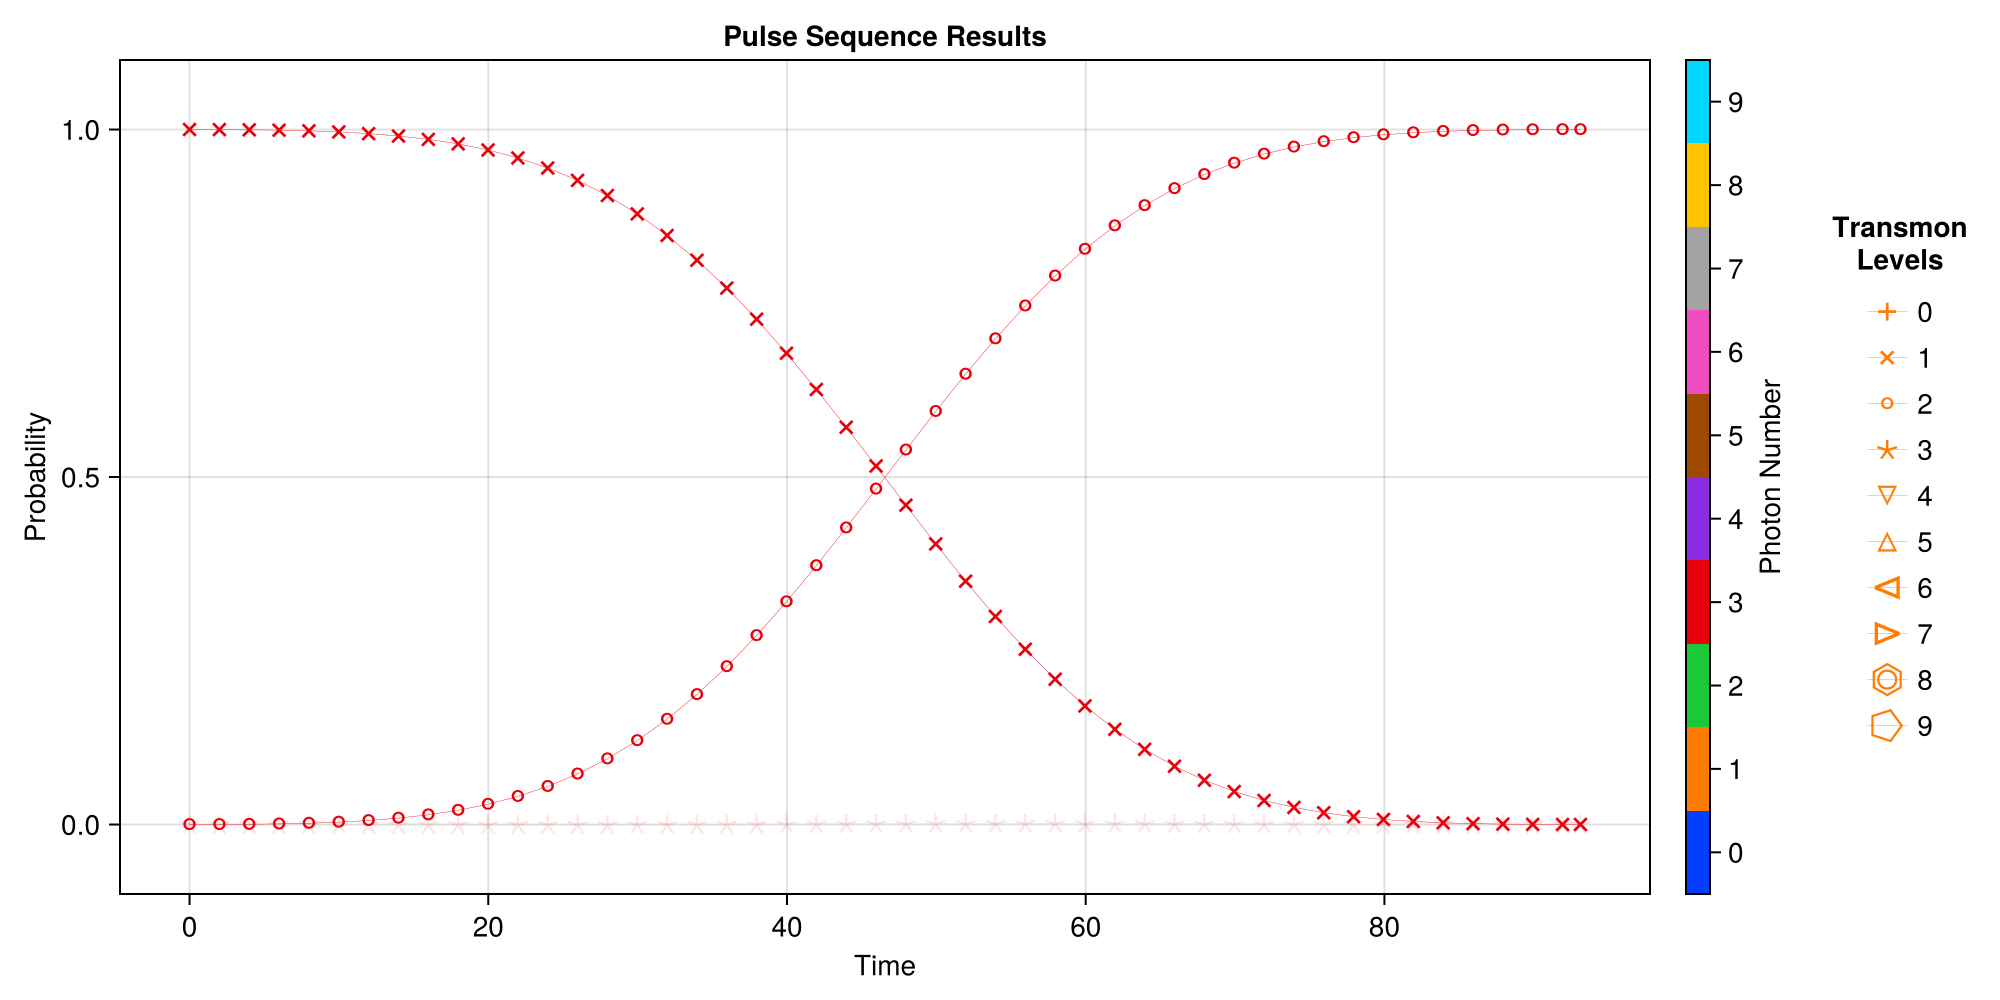

CairoMakie.Screen{IMAGE}


In [87]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [88]:
EVs[(2, 3)][end]

0.9998878454212902 + 2.726709187146947e-17im

In [89]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999994120781 + 2.7048104752037465e-17im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [90]:
starting_args = deepcopy(Mode10.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode10.dressed_states[(0,0)]
ψ2 = Mode10.dressed_states[(0,0)] + Mode10.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode10.dressed_states[(0,0)]*Mode10.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-11 12:28:11] Info: On Level 1
[2024-11-11 12:28:11] Info: On Step 1: t = 92.96875
[2024-11-11 12:28:11] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:28:13] Info: Time Evolution Complete
[2024-11-11 12:28:14] Info: Done with Level_1_step_1
[2024-11-11 12:28:14] Info: Using Check Op
[2024-11-11 12:28:14] Info: Accurace: 0.9999178567978373
[2024-11-11 12:28:14] Info: ------------------------------------------------------------------------------
[2024-11-11 12:28:14] Info: Highest Accuracy: 0.9999178567978373
[2024-11-11 12:28:14] Info: New ti: 92.96875, new tf: 92.96875
[2024-11-11 12:28:14] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999918
  "freq_d"        => 4.60422

In [91]:
#Mode10.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999918
  "freq_d"        => 4.60422

In [92]:
ψ = Mode10.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-11T12:28:15.751
It is being saved at: Data/
[2024-11-11 12:28:15] Info: Running operator q_half_ge0
[2024-11-11 12:28:15] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-11 12:28:18] Info: Time Evolution Complete
[2024-11-11 12:28:18] Info: Saving Steps
[2024-11-11 12:28:18] Info: Done with Step_1
[2024-11-11 12:28:18] Info: Done With Running Sequence
[2024-11-11 12:28:18] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [93]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-11 12:28:19] Info: Making Plot


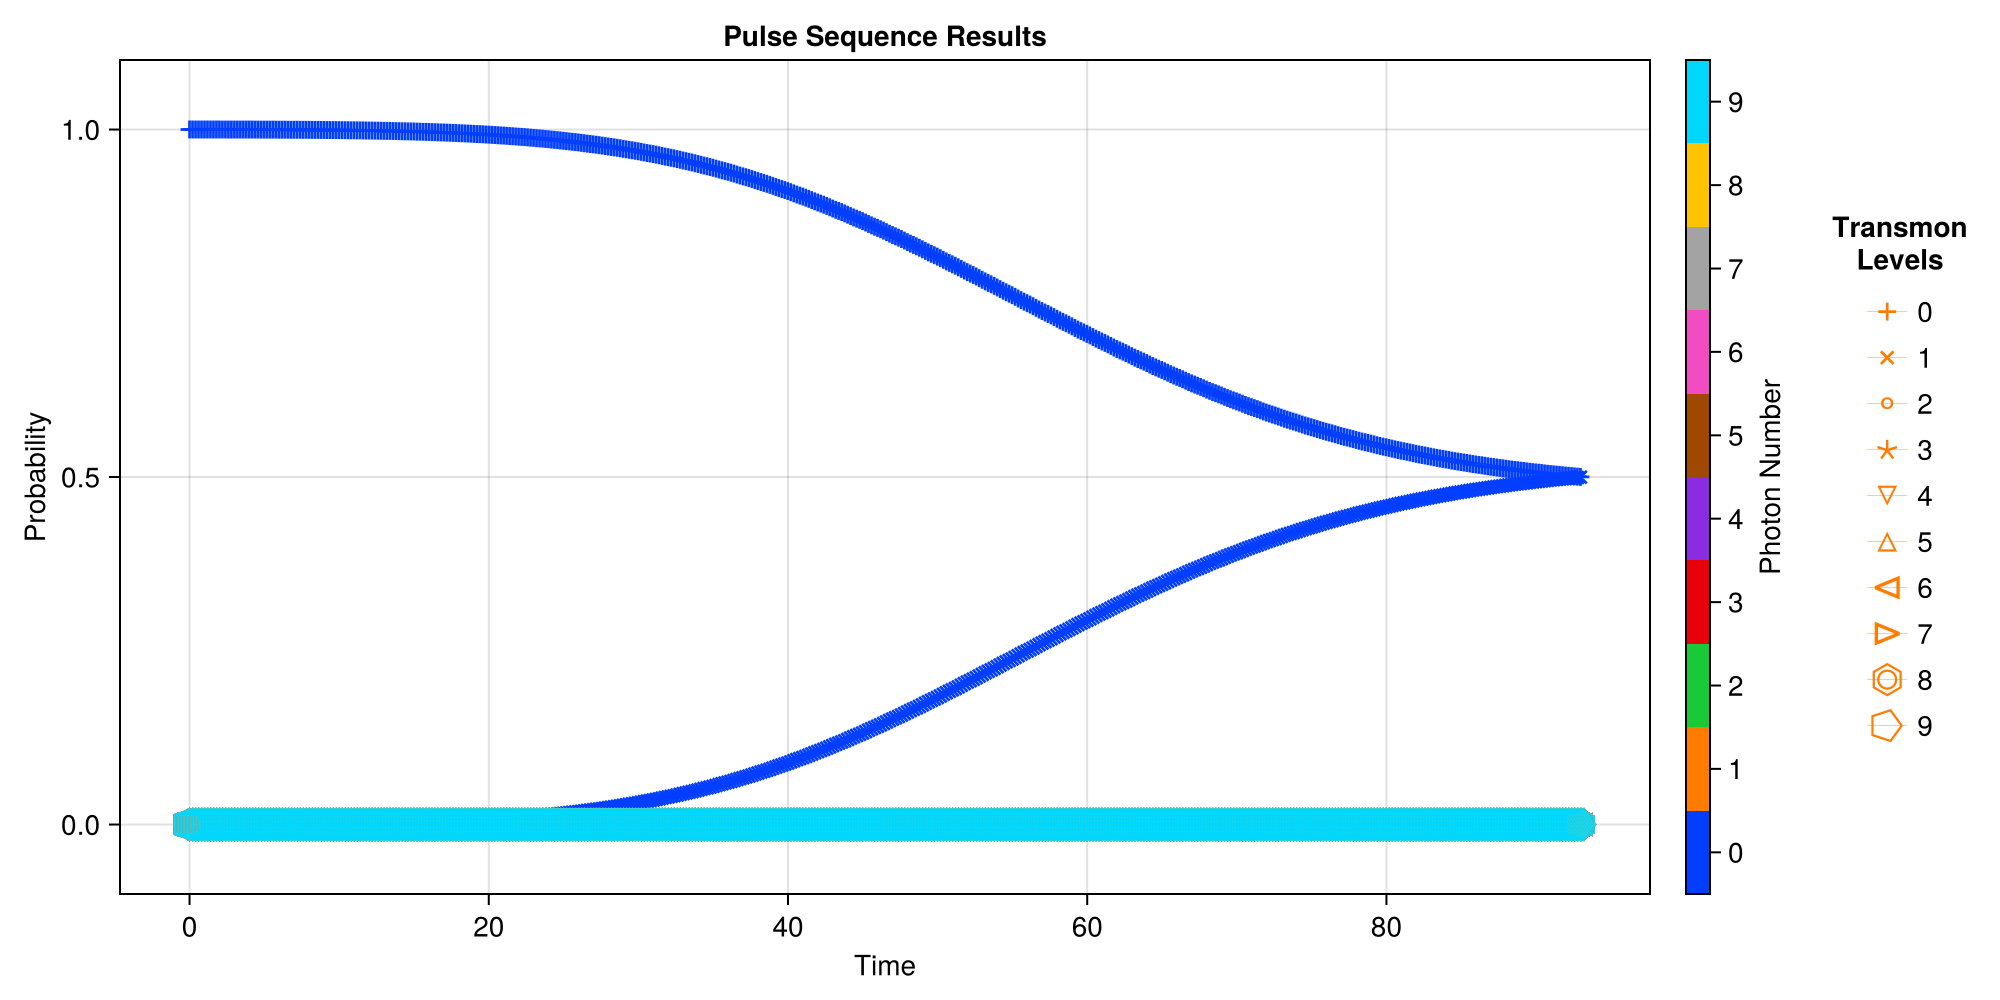

In [94]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, res_half_ge0["times"], EVs_Dict);

In [95]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.5001530758882804 - 3.6238629895166196e-17im
0.4997648562729795 + 2.417827777719163e-17im


In [7]:
SC.Utils.save_model(Mode10)

## Sidebands at $\varepsilon = 0.595$

### Getting Stark Shift

[2024-11-11 12:44:43] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


[2024-11-11 12:45:16] Info: Done With Floquet Sweep
[2024-11-11 12:45:16] Info: Fit Stuff: 3-element Vector{Float64}:	 0.021000128880237303	 0.0014821803344756603	 2.096731540373789
Stark shift res: [0.021000128880237303, 321.77783480947704]


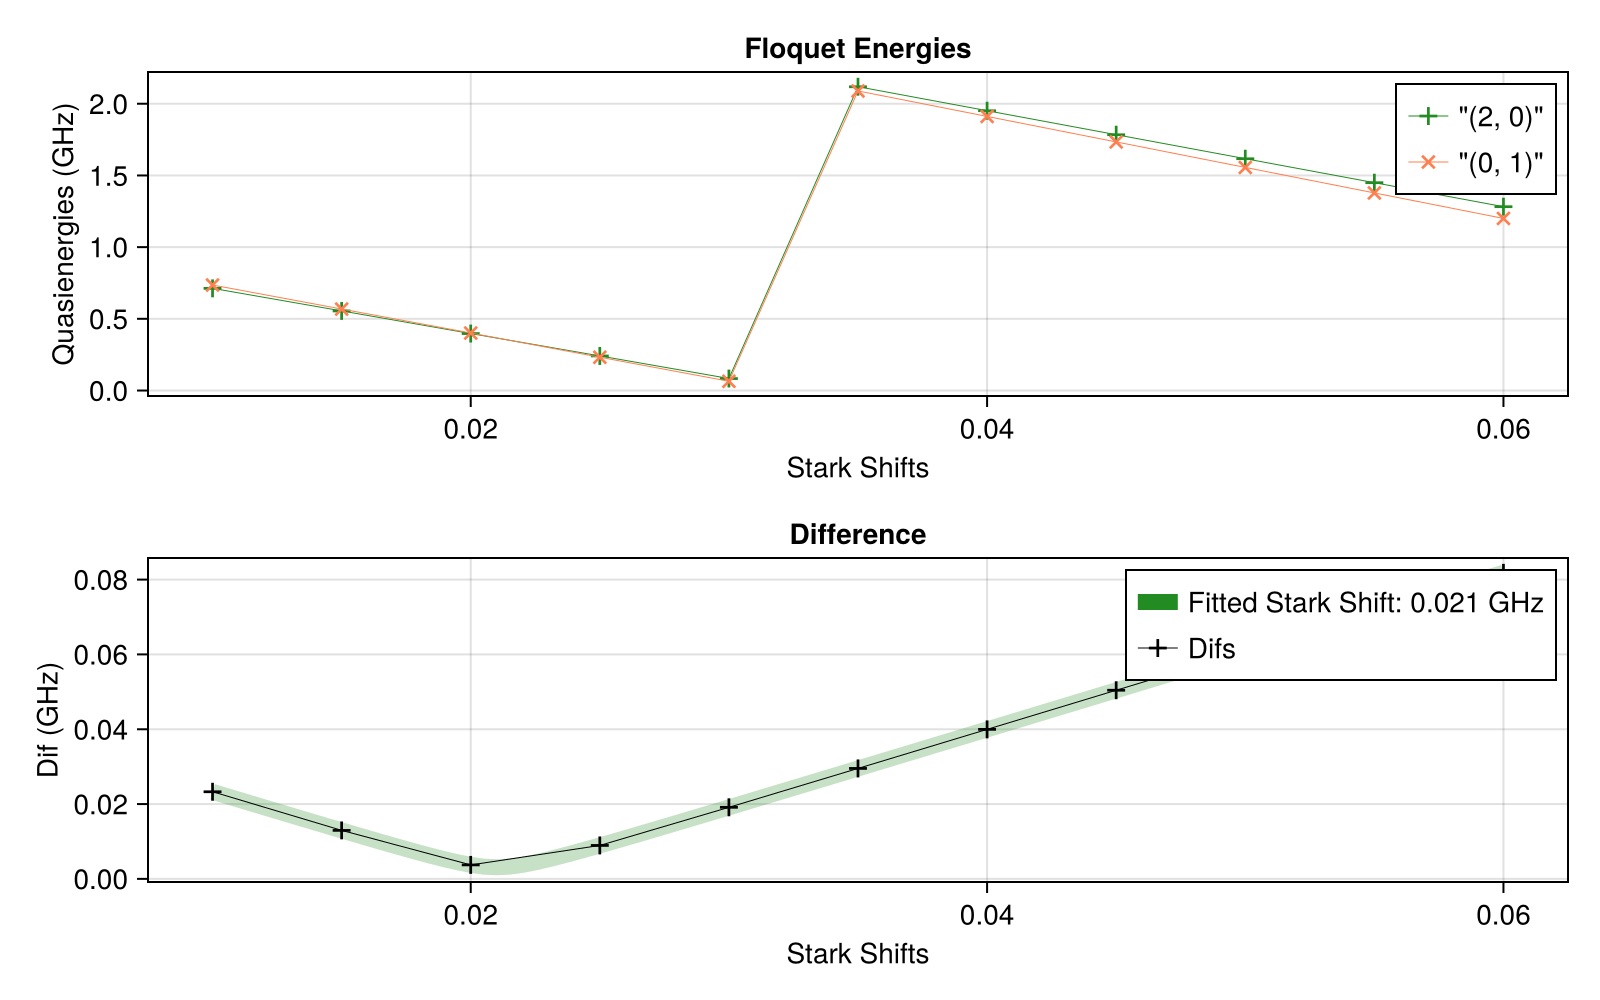

In [105]:
fngnp1_ε = 2.5
drive_op = Mode10.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.01, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode10, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [106]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [107]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][10][1]*1000))

Target flattop time: 312.0


In [108]:
ψ1 = Mode10.dressed_states[(2,0)]
ψ2 = Mode10.dressed_states[(0,1)]

freq_d = Mode10.dressed_energies[(0,1)]-Mode10.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:45:19] Info: On Level 1
[2024-11-11 12:45:19] Info: On Step 1: t = 321.77783480947704
[2024-11-11 12:45:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 09s (ETA: 0h 00m 00s)
[2024-11-11 12:45:29] Info: Time Evolution Complete
[2024-11-11 12:45:29] Info: Done with Level_1_step_1
[2024-11-11 12:45:29] Info: Accurace: 0.995835794309475
[2024-11-11 12:45:29] Info: ------------------------------------------------------------------------------
[2024-11-11 12:45:29] Info: On Step 2: t = 327.590684809477
[2024-11-11 12:45:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 09s (ETA: 0h 00m 00s)
[2024-11-11 12:45:38] Info: Time Evolution Complete
[2024-11-11 12:45:38] Info: Done with Level_1_step_2
[2024-11-11 12:45:38] Info: Accurace: 0.9986703550836301
[2024-11-11 12:45:38] Info: ------------------------------------------------------------------------------
[2024-

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 335.22
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>335.22, "k"=>2, "ramp_time"=>…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999975
  "freq_d"        => -1.1312

In [109]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

311.968650434477

In [110]:
#Mode10.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 335.22
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>335.22, "k"=>2, "ramp_time"=>…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999975
  "freq_d"        => -1.1312

In [111]:
ψ = Mode10.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-11T12:50:21.528
It is being saved at: Data/
[2024-11-11 12:50:21] Info: Running operator sb_f0g1
[2024-11-11 12:50:21] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 10s (ETA: 0h 00m 00s)
[2024-11-11 12:50:32] Info: Time Evolution Complete
[2024-11-11 12:50:32] Info: Saving Steps
[2024-11-11 12:50:33] Info: Done with Step_1
[2024-11-11 12:50:33] Info: Done With Running Sequence
[2024-11-11 12:50:33] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199893, 0.399785, 0.599678, 0.799571, 0.999463, 1.1993…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [112]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-11 12:50:35] Info: Making Plot


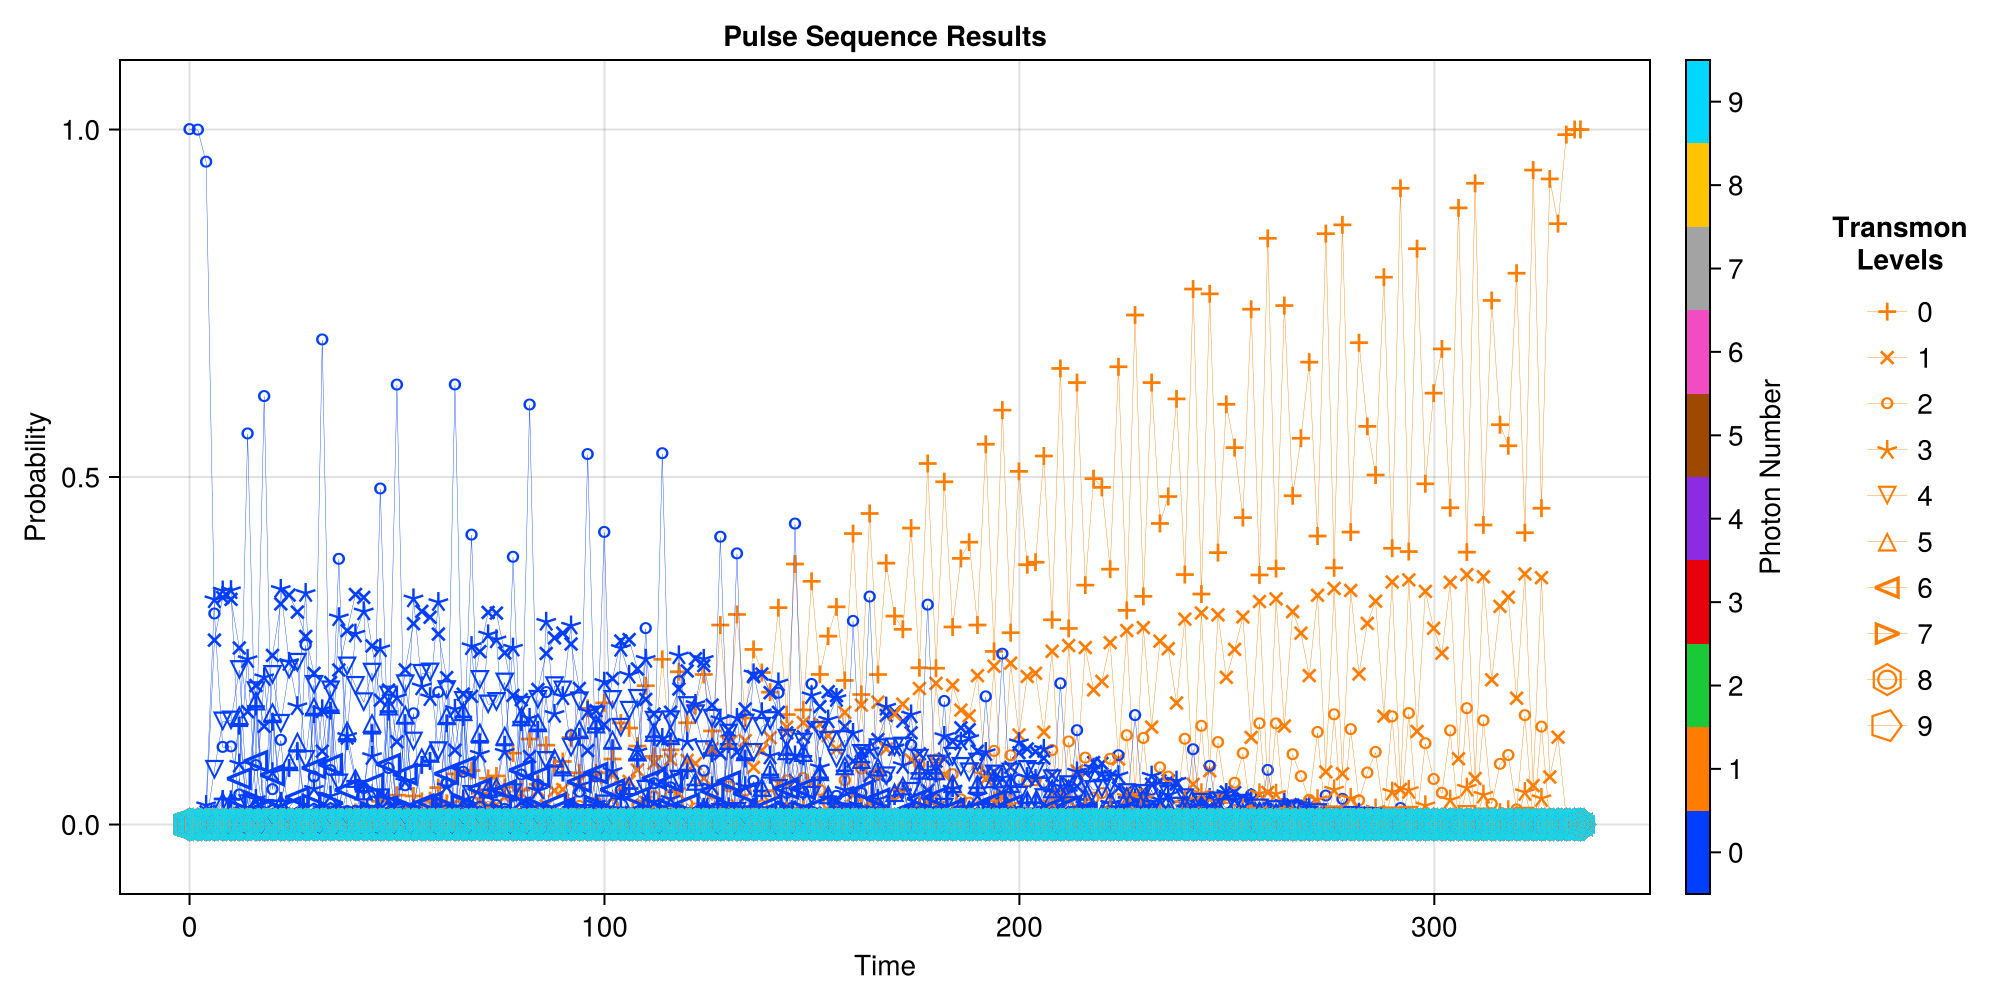

CairoMakie.Screen{IMAGE}


In [113]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [114]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][10][2]*1000))

Target flattop time: 226.0913970188941


In [115]:
ψ1 = Mode10.dressed_states[(2,1)]
ψ2 = Mode10.dressed_states[(0,2)]

freq_d = Mode10.dressed_energies[(0,2)]-Mode10.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:50:40] Info: On Level 1
[2024-11-11 12:50:40] Info: On Step 1: t = 227.5312890293059
[2024-11-11 12:50:40] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-11 12:50:46] Info: Time Evolution Complete
[2024-11-11 12:50:46] Info: Done with Level_1_step_1
[2024-11-11 12:50:46] Info: Accurace: 0.9920854733674954
[2024-11-11 12:50:46] Info: ------------------------------------------------------------------------------
[2024-11-11 12:50:46] Info: On Step 2: t = 233.3441390293059
[2024-11-11 12:50:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-11-11 12:50:54] Info: Time Evolution Complete
[2024-11-11 12:50:54] Info: Done with Level_1_step_2
[2024-11-11 12:50:54] Info: Accurace: 0.9975248064891891
[2024-11-11 12:50:54] Info: ------------------------------------------------------------------------------
[2024

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 240.247
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>240.247, "k"=>2, "ramp_time"=…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999861
  "freq_d"        => -1.13101

In [116]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

216.99549840430592

In [117]:
#Mode10.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 240.247
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>240.247, "k"=>2, "ramp_time"=…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999861
  "freq_d"        => -1.13101

### f2->g3

In [118]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][10][3]*1000))

Target flattop time: 184.6028526431001


In [119]:
ψ1 = Mode10.dressed_states[(2,2)]
ψ2 = Mode10.dressed_states[(0,3)]

freq_d = Mode10.dressed_energies[(0,3)]-Mode10.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:53:30] Info: On Level 1
[2024-11-11 12:53:30] Info: On Step 1: t = 185.77851954650652
[2024-11-11 12:53:30] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-11 12:53:36] Info: Time Evolution Complete
[2024-11-11 12:53:36] Info: Done with Level_1_step_1
[2024-11-11 12:53:36] Info: Accurace: 0.9883888407806234
[2024-11-11 12:53:36] Info: ------------------------------------------------------------------------------
[2024-11-11 12:53:36] Info: On Step 2: t = 191.59136954650654
[2024-11-11 12:53:36] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-11 12:53:42] Info: Time Evolution Complete
[2024-11-11 12:53:42] Info: Done with Level_1_step_2
[2024-11-11 12:53:42] Info: Accurace: 0.9963902062799017
[2024-11-11 12:53:42] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 198.494
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>198.494, "k"=>2, "ramp_time"=…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999722
  "freq_d"        => -1.13081

In [120]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

175.2427289215065

In [121]:
#Mode10.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 198.494
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>198.494, "k"=>2, "ramp_time"=…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999722
  "freq_d"        => -1.13081

### f3->g4

In [122]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][10][4]*1000))

Target flattop time: 159.87076


In [123]:
ψ1 = Mode10.dressed_states[(2,3)]
ψ2 = Mode10.dressed_states[(0,4)]

freq_d = Mode10.dressed_energies[(0,4)]-Mode10.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-11 12:55:52] Info: On Level 1
[2024-11-11 12:55:52] Info: On Step 1: t = 160.88891740473852
[2024-11-11 12:55:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-11 12:55:57] Info: Time Evolution Complete
[2024-11-11 12:55:57] Info: Done with Level_1_step_1
[2024-11-11 12:55:57] Info: Accurace: 0.9847286982506382
[2024-11-11 12:55:57] Info: ------------------------------------------------------------------------------
[2024-11-11 12:55:57] Info: On Step 2: t = 166.70176740473852
[2024-11-11 12:55:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-11 12:56:02] Info: Time Evolution Complete
[2024-11-11 12:56:02] Info: Done with Level_1_step_2
[2024-11-11 12:56:02] Info: Accurace: 0.9952674569709687
[2024-11-11 12:56:02] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 173.605
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>173.605, "k"=>2, "ramp_time"=…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999576
  "freq_d"        => -1.13062

In [124]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

150.35312677973852

In [125]:
#Mode10.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 173.605
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>173.605, "k"=>2, "ramp_time"=…
  "epsilon"       => 2.5
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0210001
  "accuracy"      => 0.999576
  "freq_d"        => -1.13062

In [126]:
SC.Utils.save_model(Mode10)

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [ ]:
n1 = 1
n2 = 3

freq1 = Mode10.dressed_energies[(2,n1)]-Mode10.dressed_energies[(0,n1+1)]
freq2 = Mode10.dressed_energies[(2,n2)]-Mode10.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.3
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0007848970006136824
m: 1.4142135623730951
n: 1
Required Epsilon: 0.0832508987500375


[2024-11-08 18:41:51] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:20


[2024-11-08 18:42:12] Info: Done With Floquet Sweep
[2024-11-08 18:42:12] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0007613188025463708	 0.0005267568261410399	 2.0028257671502483


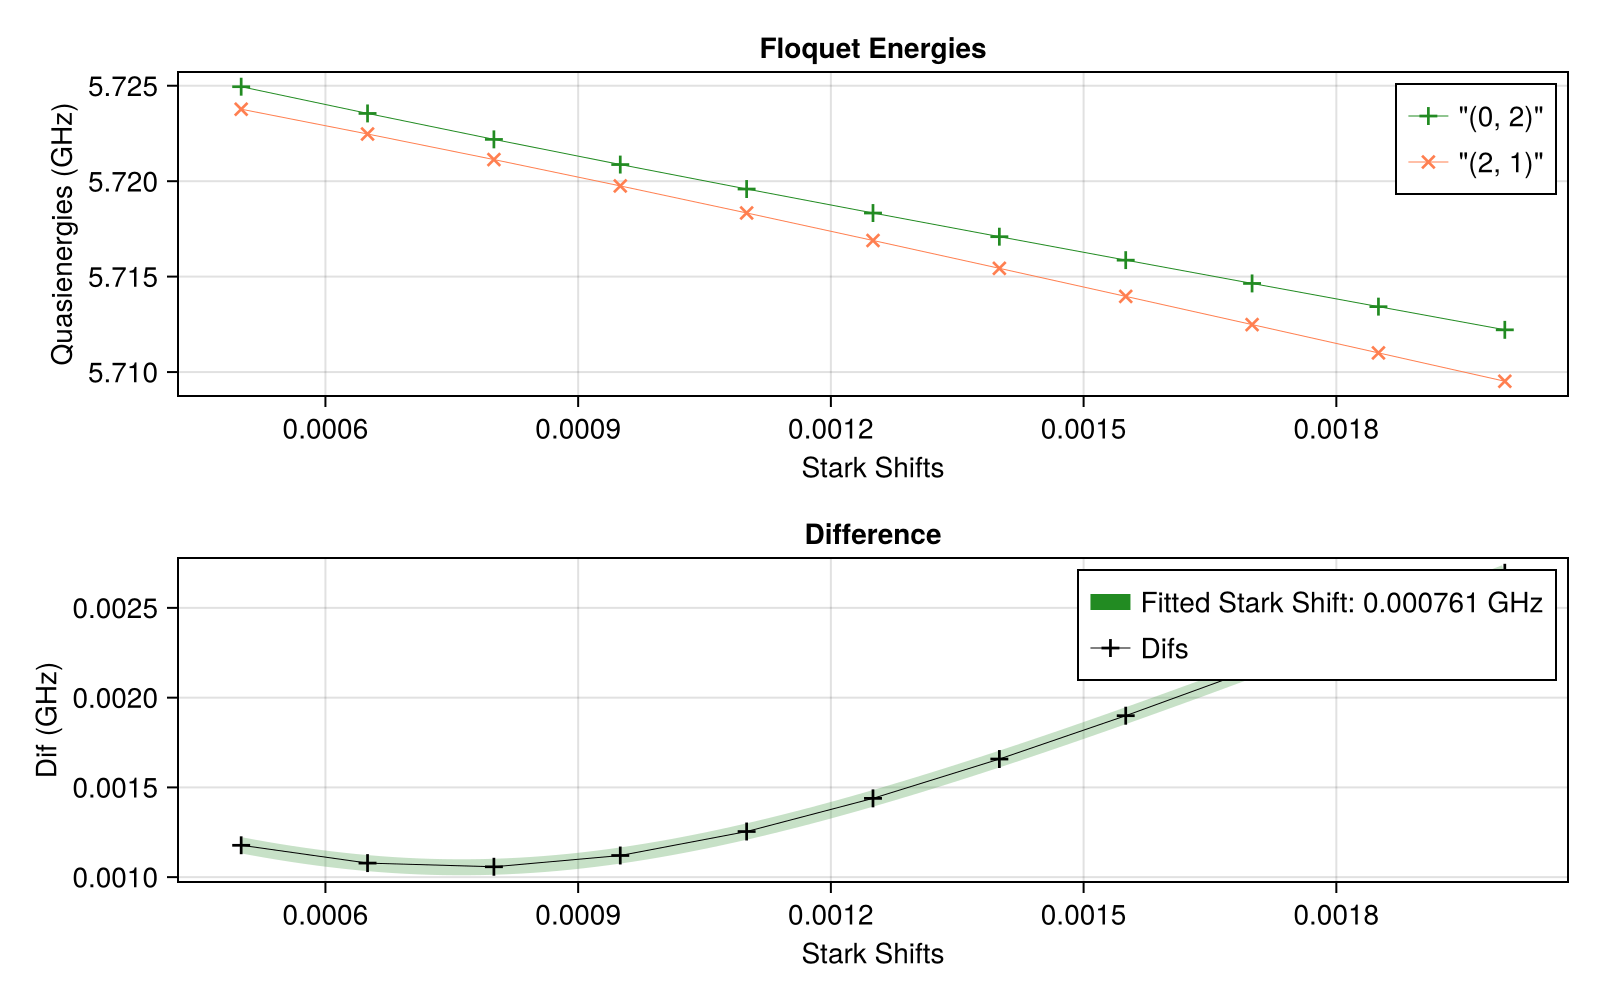

2-element Vector{Float64}:
   0.0007613188025463708
 947.8653719249797

In [ ]:
ε = eps_f1_2pi_g3
drive_op = Mode10.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.002, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode10, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [17]:
n2

3

In [ ]:
ψ1 = Mode10.dressed_states[(2,n1)]+Mode10.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode10.dressed_states[(0,n1+1)]+Mode10.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)


freq_d = Mode10.dressed_energies[(0,n1+1)]-Mode10.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

check_op = Mode10.dressed_states[(0,n1+1)]*Mode10.dressed_states[(2,n2)]'*2

stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time*0.99, initial_time*1.01]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 7, check_op = check_op);

[2024-11-08 18:42:12] Info: On Level 1
[2024-11-08 18:42:12] Info: On Step 1: t = 938.38671820573
[2024-11-08 18:42:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 42s (ETA: 0h 00m 00s)
[2024-11-08 18:42:55] Info: Time Evolution Complete
[2024-11-08 18:42:55] Info: Done with Level_1_step_1
[2024-11-08 18:42:55] Info: Using Check Op
[2024-11-08 18:42:55] Info: Accurace: 0.9993598958222756
[2024-11-08 18:42:55] Info: ------------------------------------------------------------------------------
[2024-11-08 18:42:55] Info: On Step 2: t = 941.5462694454799
[2024-11-08 18:42:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 43s (ETA: 0h 00m 00s)
[2024-11-08 18:43:39] Info: Time Evolution Complete
[2024-11-08 18:43:39] Info: Done with Level_1_step_2
[2024-11-08 18:43:39] Info: Using Check Op
[2024-11-08 18:43:39] Info: Accurace: 0.9994618631727932
[2024-11-08 18:43:39] Info: 

In [19]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

921.4544206852298

In [ ]:
#Mode10.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 944.706
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>944.706, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0832509
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000761319
  "accuracy"      => 0.999482
  "freq_d"        => -3.10383

In [ ]:
ψ = Mode10.dressed_states[(2,1)]+Mode10.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T18:48:49.463
It is being saved at: Data/
[2024-11-08 18:48:49] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-08 18:48:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 41s (ETA: 0h 00m 00s)
[2024-11-08 18:49:30] Info: Time Evolution Complete
[2024-11-08 18:49:30] Info: Saving Steps
[2024-11-08 18:49:37] Info: Done with Step_1
[2024-11-08 18:49:37] Info: Done With Running Sequence
[2024-11-08 18:49:37] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.19998, 0.39996, 0.59994, 0.79992, 0.9999, 1.19988, 1.3…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [22]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-08 18:49:42] Info: Making Plot


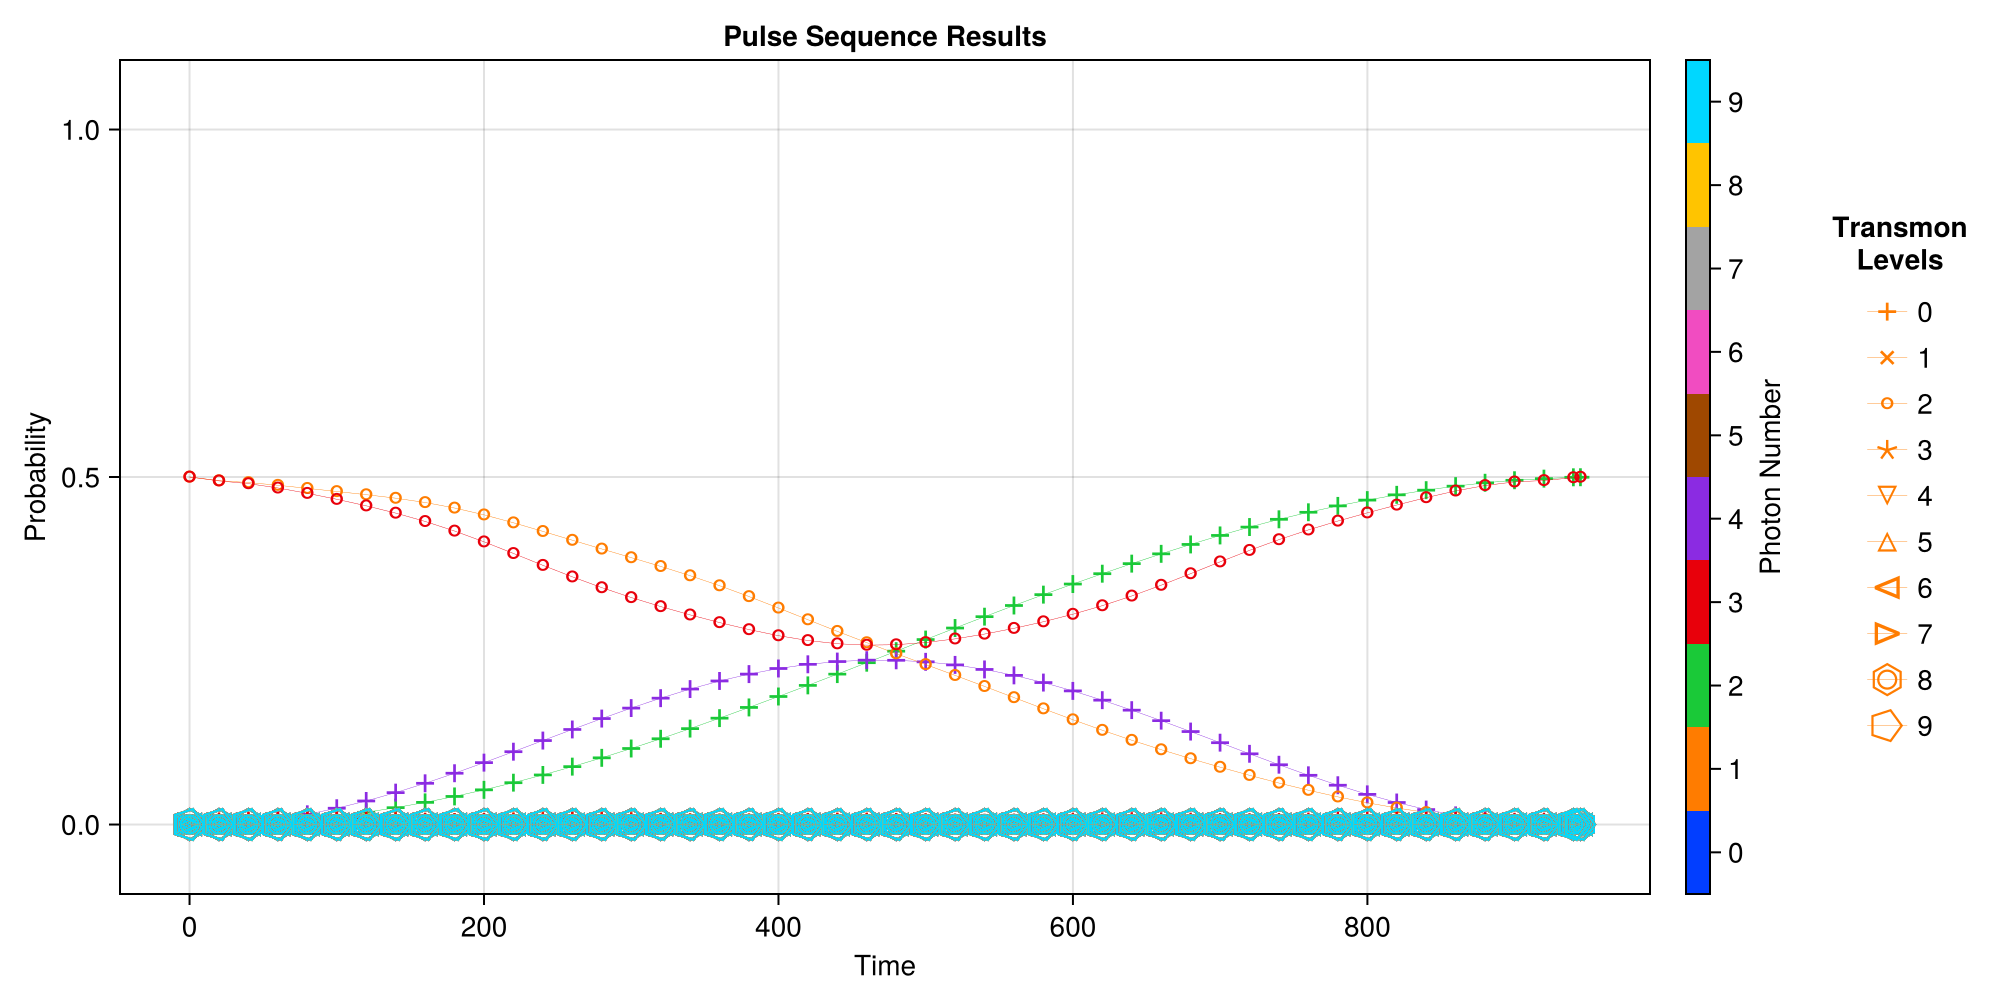

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, res_f1g2_2pi_f3g4["times"], EVs_Dict, plot_every = 100)

In [24]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.49979117254934646 + 4.706245818708166e-17im
0.4996905168282355 + 6.065084884910372e-17im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [ ]:
n1 = 0
n2 = 3

freq1 = Mode10.dressed_energies[(2,n1)]-Mode10.dressed_energies[(0,n1+1)]
freq2 = Mode10.dressed_energies[(2,n2)]-Mode10.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.45
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.001177480925420582
m: 2.0000000000000004
n: 2
Required Epsilon: 0.07647962954143757


[2024-11-08 18:55:07] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


[2024-11-08 18:55:29] Info: Done With Floquet Sweep
[2024-11-08 18:55:29] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006433530530826274	 0.0003423902156711056	 2.002387126418146


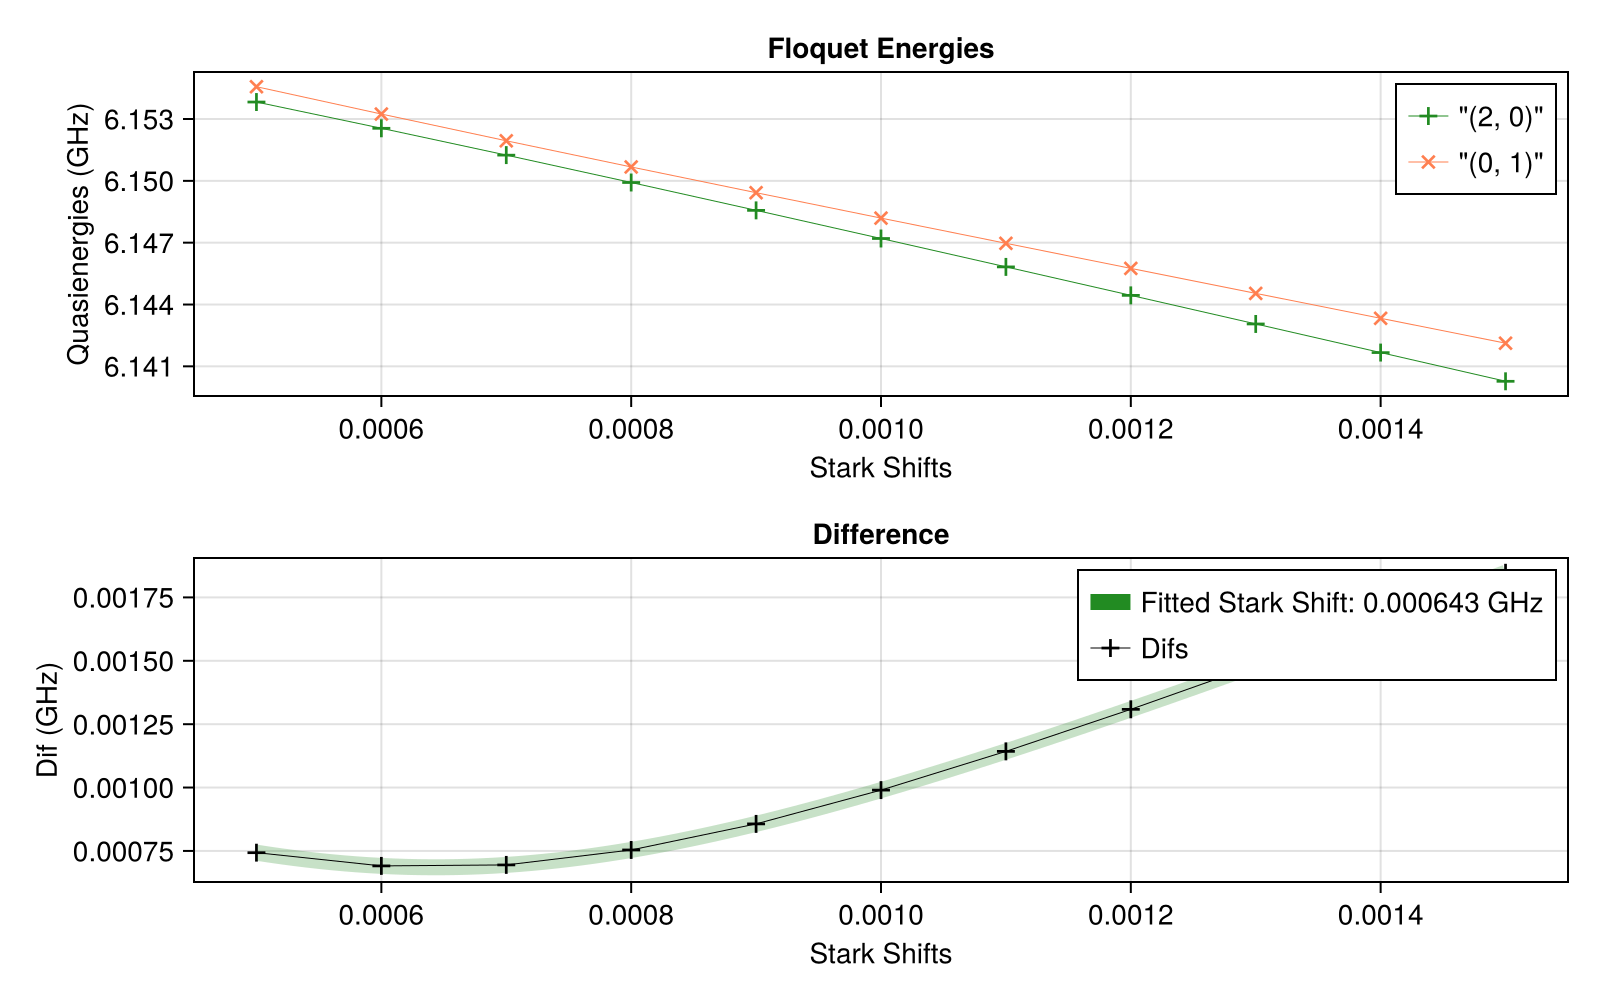

2-element Vector{Float64}:
    0.0006433530530826274
 1458.5811947459163

In [ ]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode10.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode10, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [ ]:
ψ1 = Mode10.dressed_states[(2,n1)]+Mode10.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode10.dressed_states[(0,n1+1)]+Mode10.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d = Mode10.dressed_energies[(0,n1+1)]-Mode10.dressed_energies[(2, n1)]

check_op = 2*Mode10.dressed_states[(0,n1+1)]*Mode10.dressed_states[(2,n2)]'

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 2, check_op = check_op)

[2024-11-08 18:55:29] Info: On Level 1
[2024-11-08 18:55:29] Info: On Step 1: t = 1458.5811947459163
[2024-11-08 18:55:29] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 11s (ETA: 0h 00m 00s)
[2024-11-08 18:56:41] Info: Time Evolution Complete
[2024-11-08 18:56:41] Info: Done with Level_1_step_1
[2024-11-08 18:56:41] Info: Using Check Op
[2024-11-08 18:56:41] Info: Accurace: 0.9986803501131906
[2024-11-08 18:56:41] Info: ------------------------------------------------------------------------------
[2024-11-08 18:56:41] Info: On Step 2: t = 1481.8325947459164
[2024-11-08 18:56:41] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 15s (ETA: 0h 00m 00s)
[2024-11-08 18:57:57] Info: Time Evolution Complete
[2024-11-08 18:57:57] Info: Done with Level_1_step_2
[2024-11-08 18:57:57] Info: Using Check Op
[2024-11-08 18:57:57] Info: Accurace: 0.999820378239168
[2024-11-08 18:57:57] Inf

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [ ]:
#Mode10.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1481.83
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1481.83, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.0764796
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000643353
  "accuracy"      => 0.99982
  "freq_d"        => -3.10422

In [ ]:
ψ = Mode10.dressed_states[(2,0)]+Mode10.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-08T18:58:08.288
It is being saved at: Data/
[2024-11-08 18:58:08] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-08 18:58:08] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 01m 03s (ETA: 0h 00m 00s)
[2024-11-08 18:59:12] Info: Time Evolution Complete
[2024-11-08 18:59:12] Info: Saving Steps
[2024-11-08 18:59:12] Info: Done with Step_1
[2024-11-08 18:59:12] Info: Done With Running Sequence
[2024-11-08 18:59:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999887, 1.99977, 2.99966, 3.99955, 4.99944, 5.99932, 6…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [35]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-08 18:59:13] Info: Making Plot


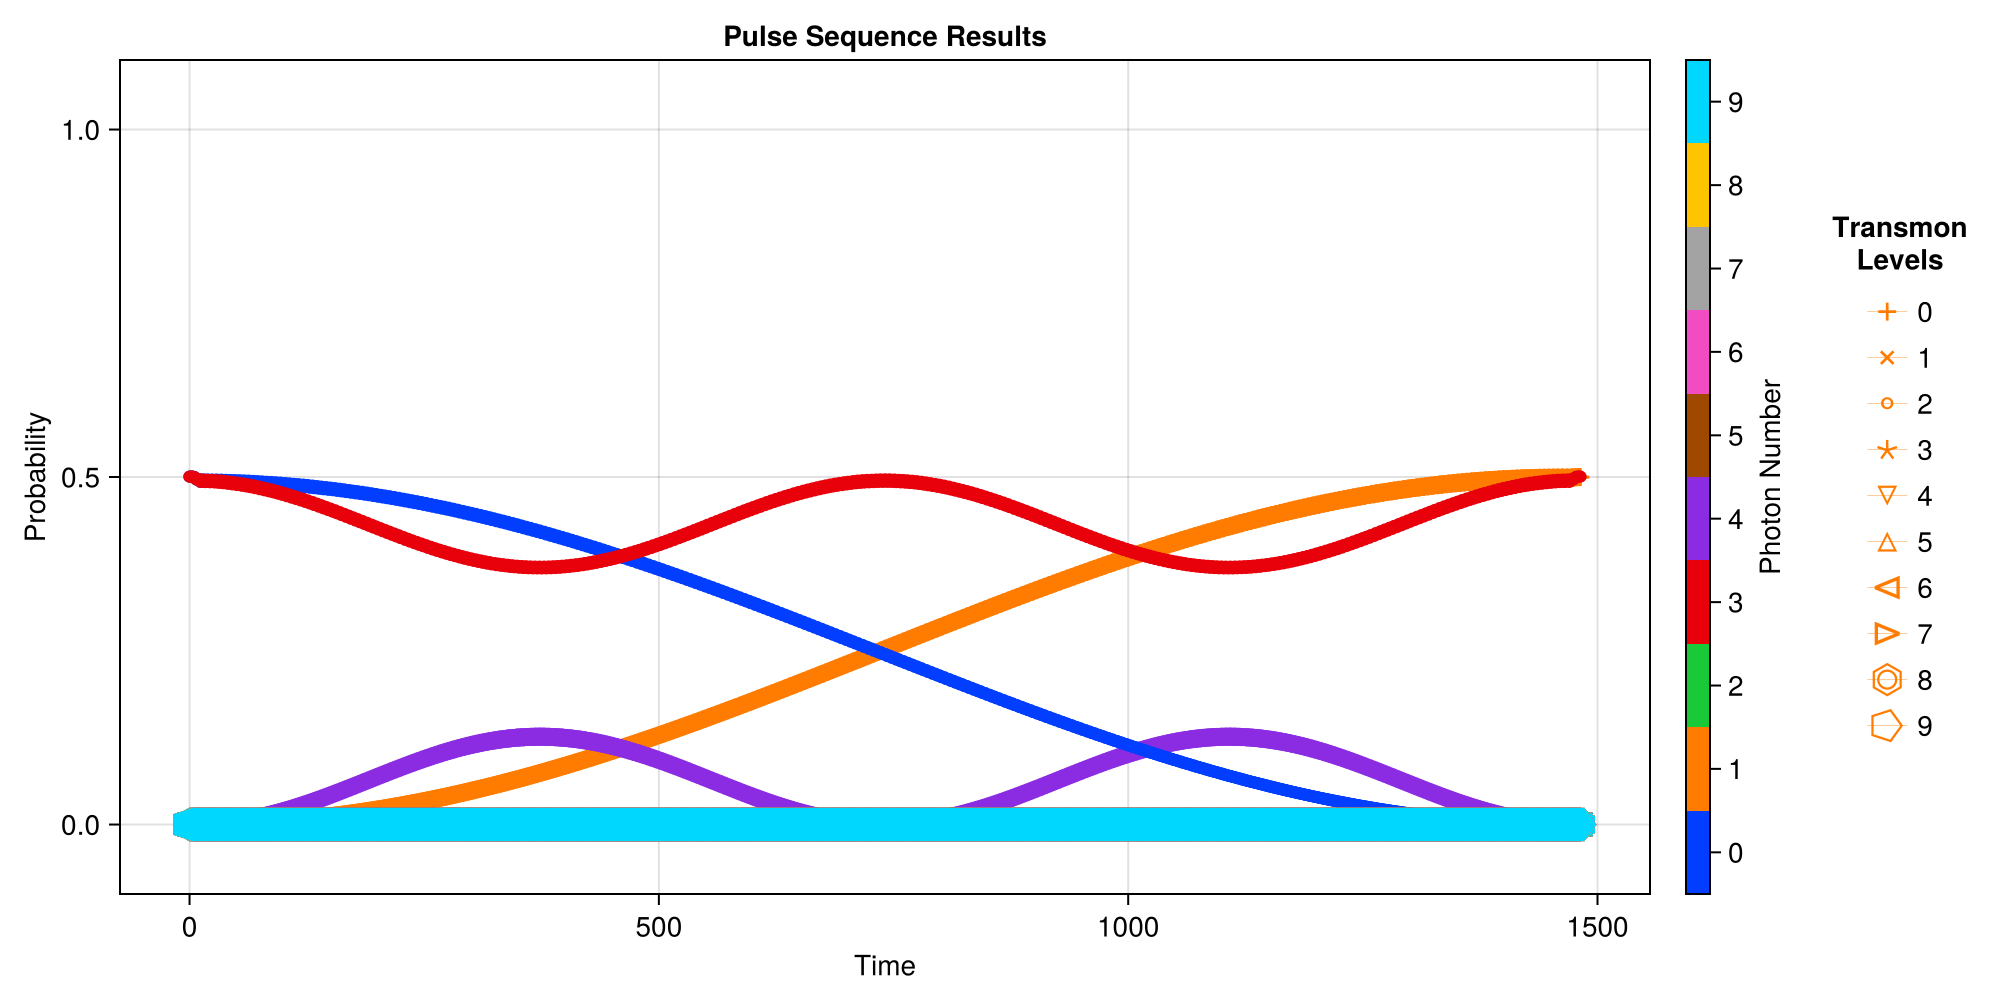

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [37]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.4999974818391036 + 3.209912380096676e-17im
0.4998153296675962 + 8.967827678057819e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [ ]:
Mode10.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

148.67000432799944

In [ ]:
starting_args = deepcopy(Mode10.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode10.dressed_states[(2,1)]
ψ2 = Mode10.dressed_states[(2,1)] + Mode10.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode10.dressed_states[(2,1)]*Mode10.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]
t_range = [starting_args["pulse_time"]*0.5, starting_args["pulse_time"]*0.7]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode10, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 25, check_op = op)

[2024-11-08 19:02:02] Info: On Level 1
[2024-11-08 19:02:02] Info: On Step 1: t = 74.33500216399972
[2024-11-08 19:02:02] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:02:07] Info: Time Evolution Complete
[2024-11-08 19:02:07] Info: Done with Level_1_step_1
[2024-11-08 19:02:07] Info: Using Check Op
[2024-11-08 19:02:07] Info: Accurace: 0.9903045931640259
[2024-11-08 19:02:07] Info: ------------------------------------------------------------------------------
[2024-11-08 19:02:07] Info: On Step 2: t = 75.57391886673305
[2024-11-08 19:02:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 19:02:11] Info: Time Evolution Complete
[2024-11-08 19:02:11] Info: Done with Level_1_step_2
[2024-11-08 19:02:11] Info: Using Check Op
[2024-11-08 19:02:11] Info: Accurace: 0.9938610397870073
[2024-11-08 19:02:11] Info

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [ ]:
#Mode10.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode10.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 80.5296
  "Envelope Args" => Dict{String, Any}("pulse_time"=>80.5296, "k"=>2, "ramp_tim…
  "epsilon"       => 0.595
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0372046
  "accuracy"      => 0.999994
  "freq_d"        => -3.10383

In [ ]:
ψ = Mode10.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode10, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T19:03:32.612
It is being saved at: Data/
[2024-11-08 19:03:32] Info: Running operator sb_half_f1g2
[2024-11-08 19:03:32] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 19:03:36] Info: Time Evolution Complete
[2024-11-08 19:03:36] Info: Saving Steps
[2024-11-08 19:03:37] Info: Done with Step_1
[2024-11-08 19:03:37] Info: Done With Running Sequence
[2024-11-08 19:03:37] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199825, 0.399651, 0.599476, 0.799301, 0.999126, 1.1989…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [56]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

[2024-11-08 19:03:38] Info: Making Plot


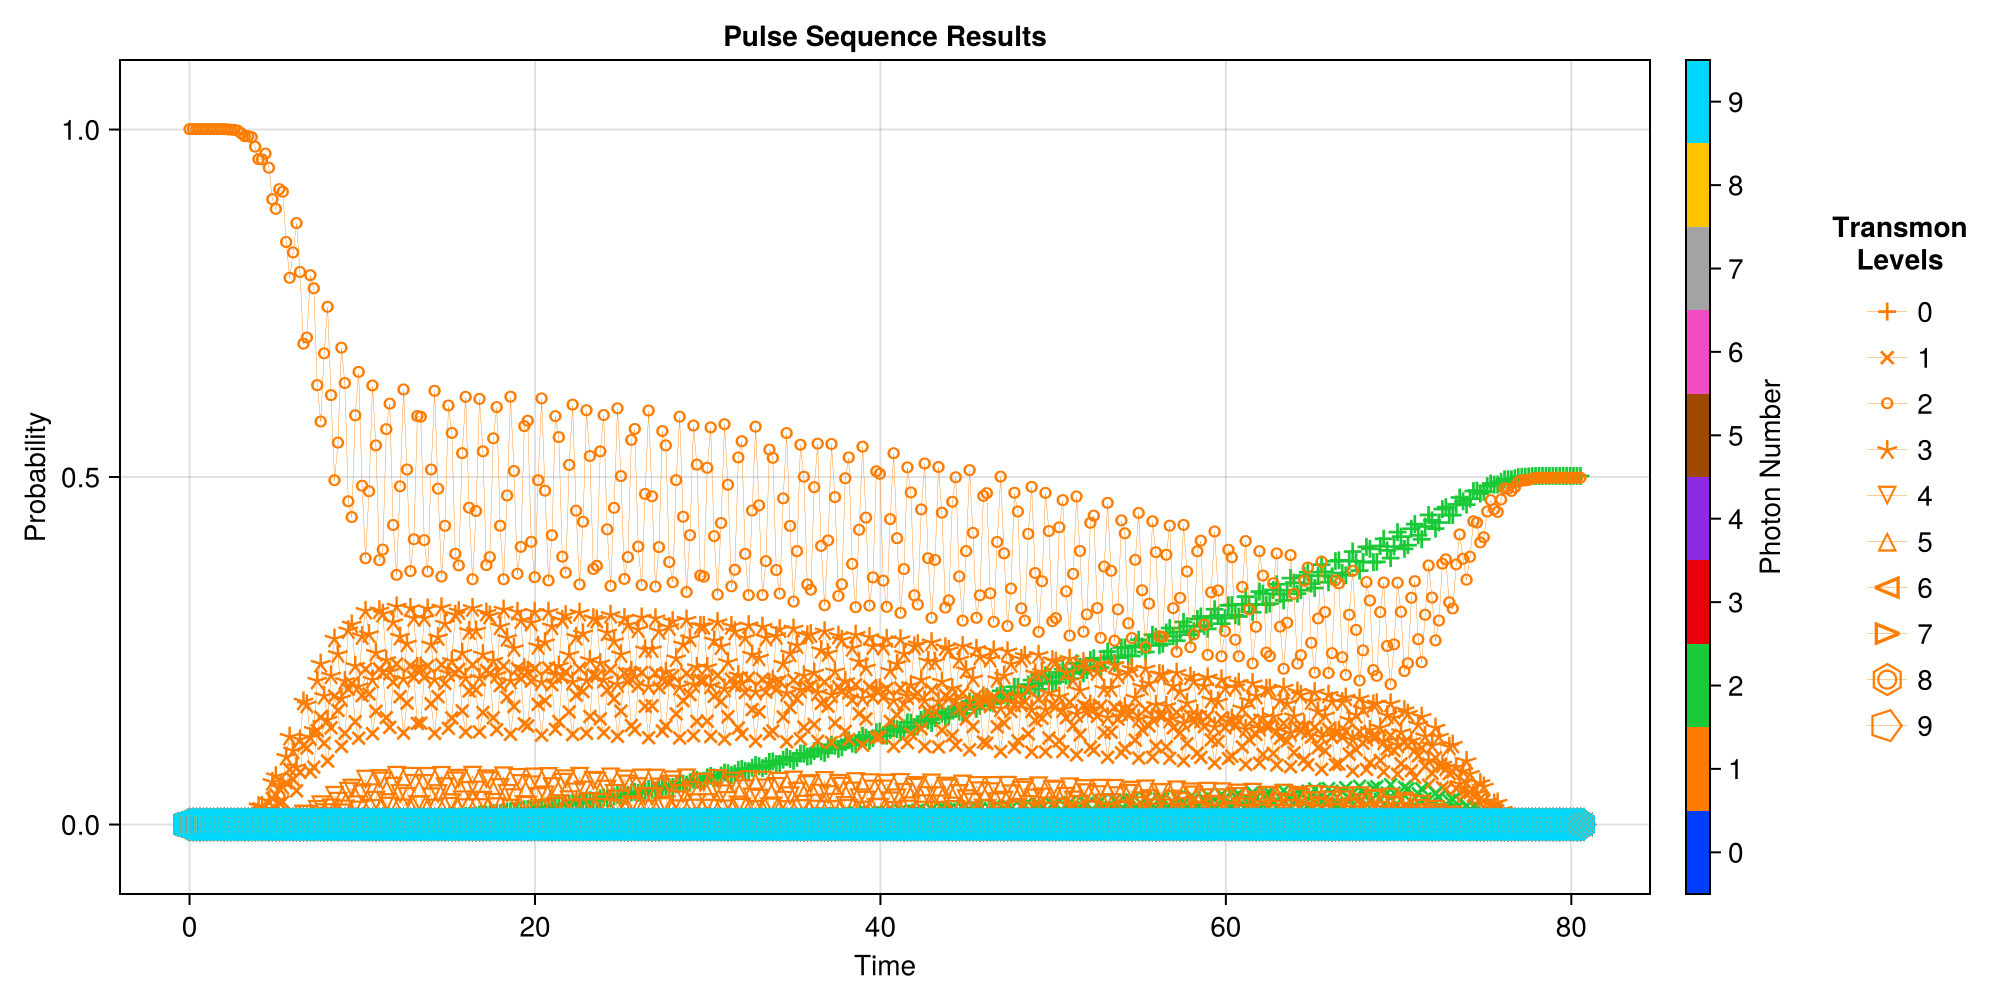

CairoMakie.Screen{IMAGE}


In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode10, res_half_f1g2["times"], EVs_Dict)

In [58]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])

0.49842784624199354 + 3.047257166760866e-18im
0.5015715525412404 - 3.656046931258164e-17im
